In [1]:
!pip install higher

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import higher

import sys
sys.path.append('helpers')

## Meta Learning for Regression Using Closed Form Min-norm Solution

As described in the setup to the theory portion of this problem, we wish to learn a good set of feature weights for regression on tasks sampled from a distribution $\mathcal{D}_T$. We define this distribution in the cell below with several entries in `params_dict`. Specifically, the true feature indices are set by `k_idx` to be $\{5,6,7,8,9,10,11\}$ by default and the true coefficients of the features are generated with i.i.d $U[-1, 1]$ samples then normalized to have total length 1. The total number of features is set by `d` in the params dictionary. The $x$ sample spacing for the inner loop of training is determined by `x_type`, while the meta update is always performed using uniform random spaced samples (otherwise we can't differentiate between aliased features). For now we will use only uniform random samples. This is the most natural version since we require uniform random samples for the meta update and there's no reason we would have a different spacing for the inner training loop.

One significant difference between MAML as described in the original paper and as we use it in the notebook is that **we use the closed form min-norm solution for regression instead of gradient descent**. Fortunately for us, PyTorch is able to backpropagate gradients through matrix inversion which means that we can update our feature weights even though we use the min-norm least squares solution rather than gradient descent steps to choose our coefficients. In later parts we use gradient descent for the inner loop instead.

In [3]:
from utils_reg import meta_learning_reg_closed_form

def get_params_dict_reg():
    
    params_dict = {
        #Parameters
    'seed':7,
    'n_train_inner':32, #Number of training samples for training inner task
    'n_train_meta':64, #Number of training samples for updating the meta parameter

    'n_train_post':32, #Number of training samples used after meta training has been done to learn the weights
    'n_test_post':1000, #Number of samples used for plotting and evaluating test performance after meta training has been done 

    # 'x_type':'uniform_random', #sampling time for inner and post training tasks
    # 'x_type':'grid', #sampling time for training tasks

    'd':501, #Number of features
    'phi_type':'fourier', #Feature type
     'noise_std':1e-1, #standard deviation of awgn noise added during training 
    'optimizer_type':'SGD', #Can be either SGD or Adam
    'k_idx':np.arange(5,11), #Frequency range present in tasks during meta training
    'stepsize_meta':1e-2, #Stepsize used for meta updates

     'num_inner_tasks':5, #Number of inner tasks for each meta update   
    'num_tasks_test':10, #Number of tasks to test on
    'num_stats': 10, #Determines how often we collect stats

    'num_iterations':100, #Iterations for training meta parameter
        'num_n_train_post_range':40, #How many points do we use to generative test loss vs n_train_post curve

    }
    return params_dict
        


## Training points on a grid

For the following cell, we choose the inner loop training data spacing to grid, the spacing you worked with in the theory portions of this problem. The meta update and test data spacings remain uniform random. This means that during the inner training the features within each alias group are identical, but each feature is unique during the meta update and for the test error.

You should see the feature weights behave similarly to your limits in that the true features get favored (i.e have higher weights) but there will be a stark differnce in how certain other feature weights behave. 

### (e)  Run the next two cells and answer the following questions:

1. Based on the plot of regression test loss vs n_train_post, how do the meta-learned feature weights perform compared to the case where all feature weights are 1? How do the meta-learned feature weights perform compared to the oracle (that performs regression only using the features present in the data)? Why is there a downward spike at n_train_post = 32?

2. By looking at the evolution of the feature-weights with time as we perform meta-learning can you justify the improvement in performance? In particular, can you explain why some feature weights are being sent towards zero?



----------------------------------------------------------------------
Iteration:  0


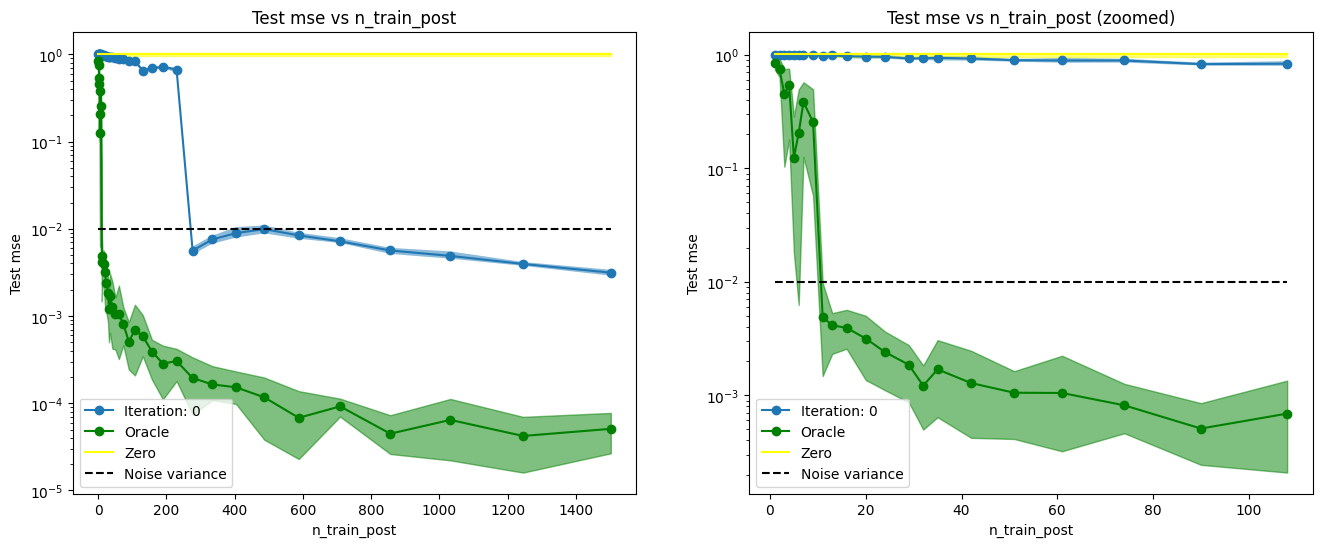

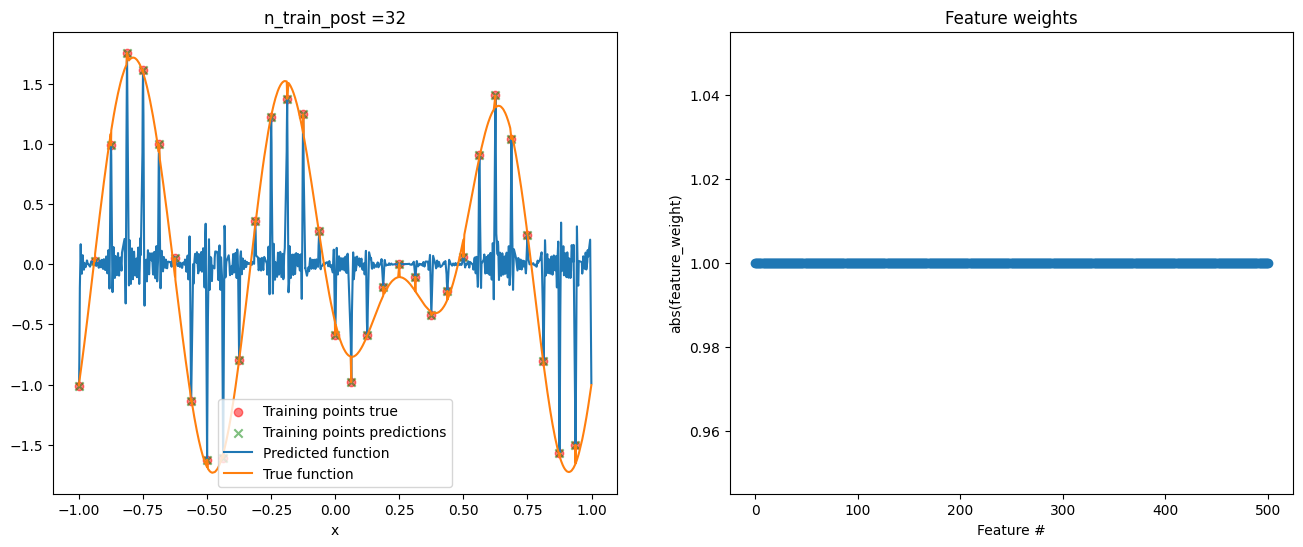

----------------------------------------------------------------------
Iteration:  10


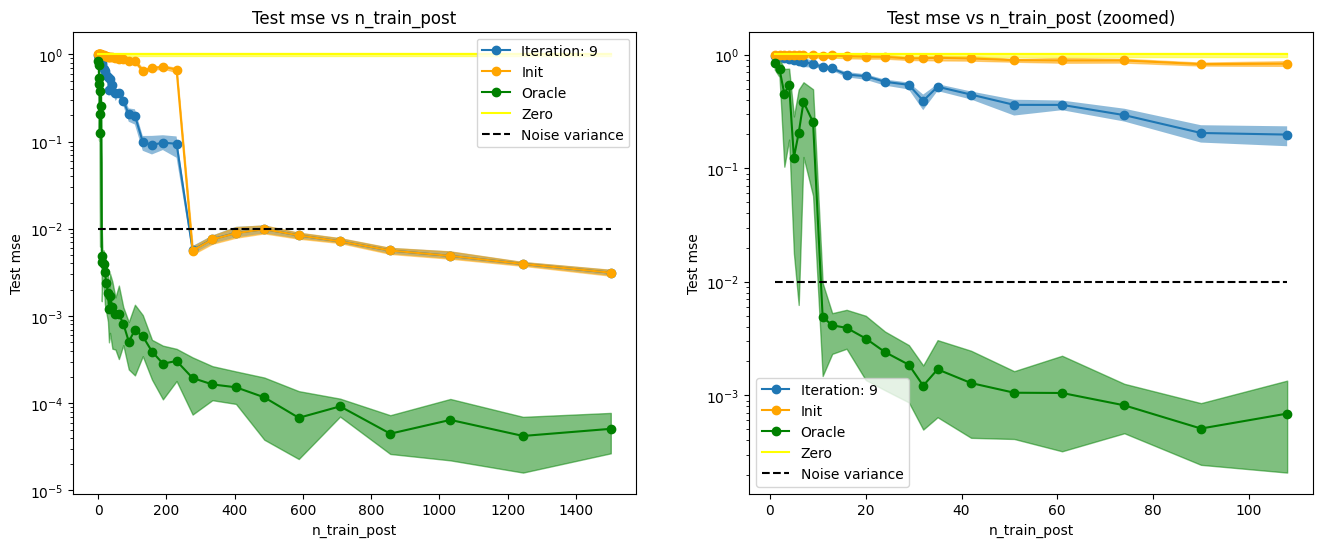

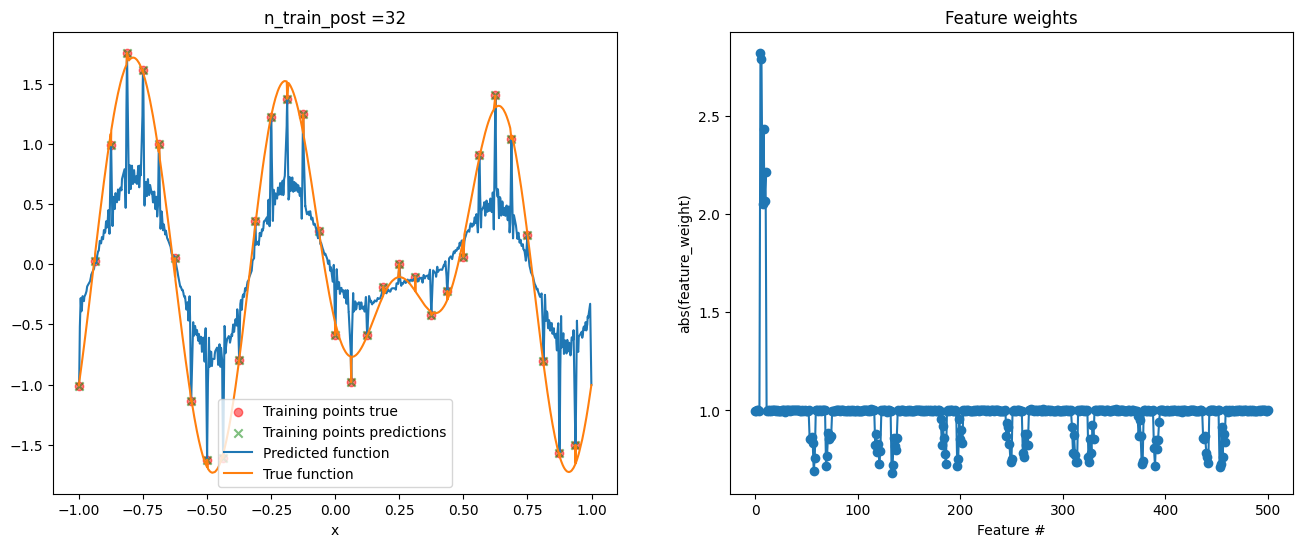

----------------------------------------------------------------------
Iteration:  20


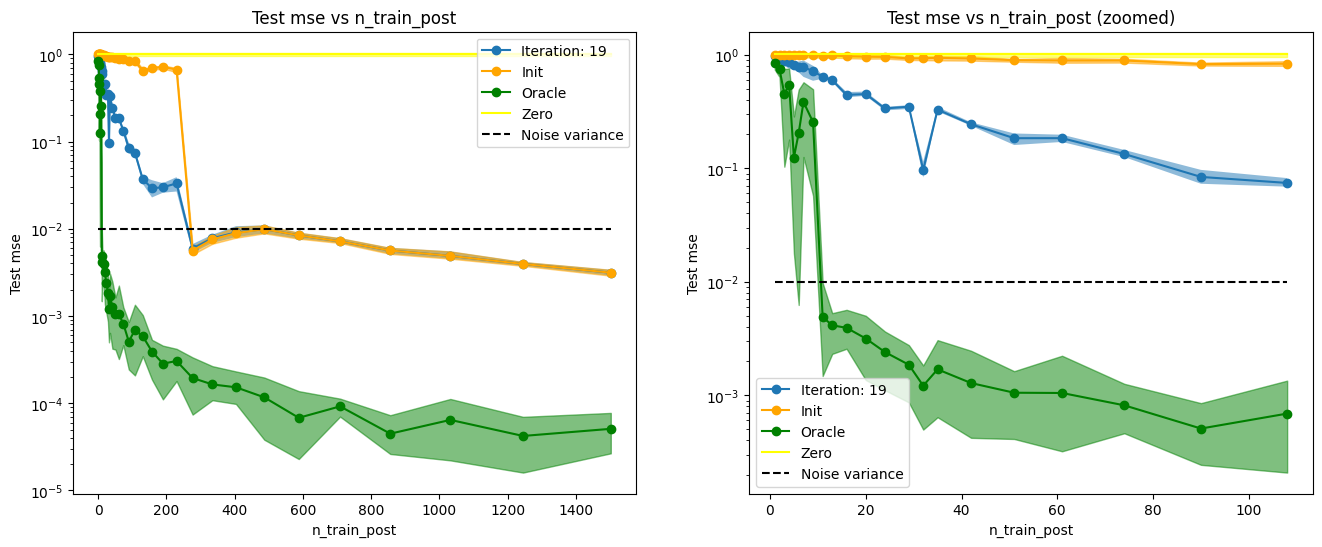

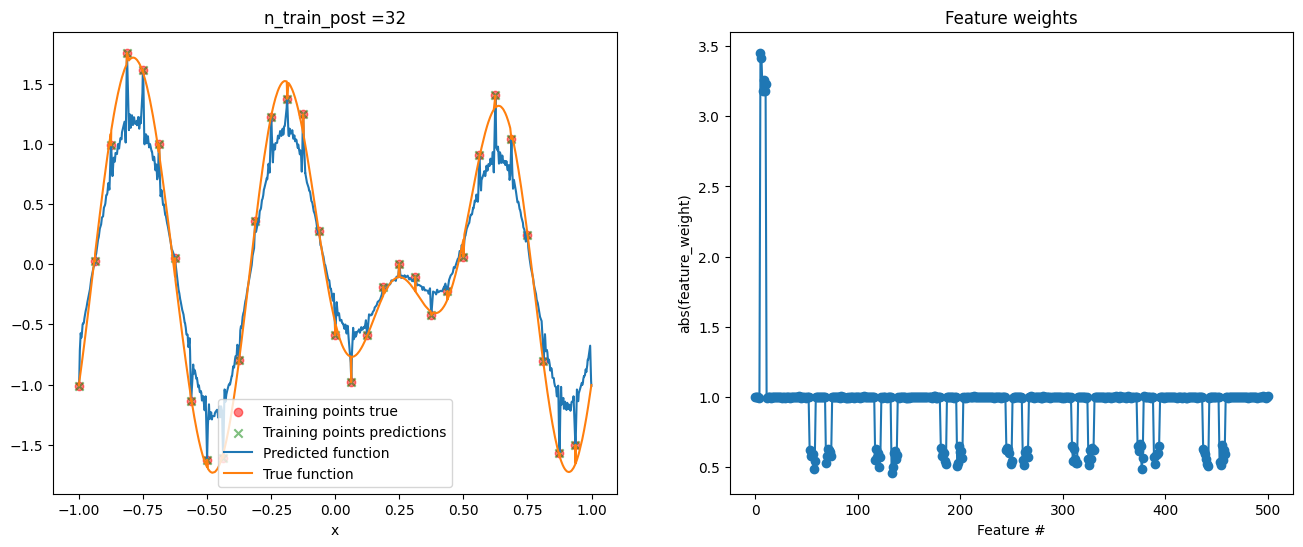

----------------------------------------------------------------------
Iteration:  30


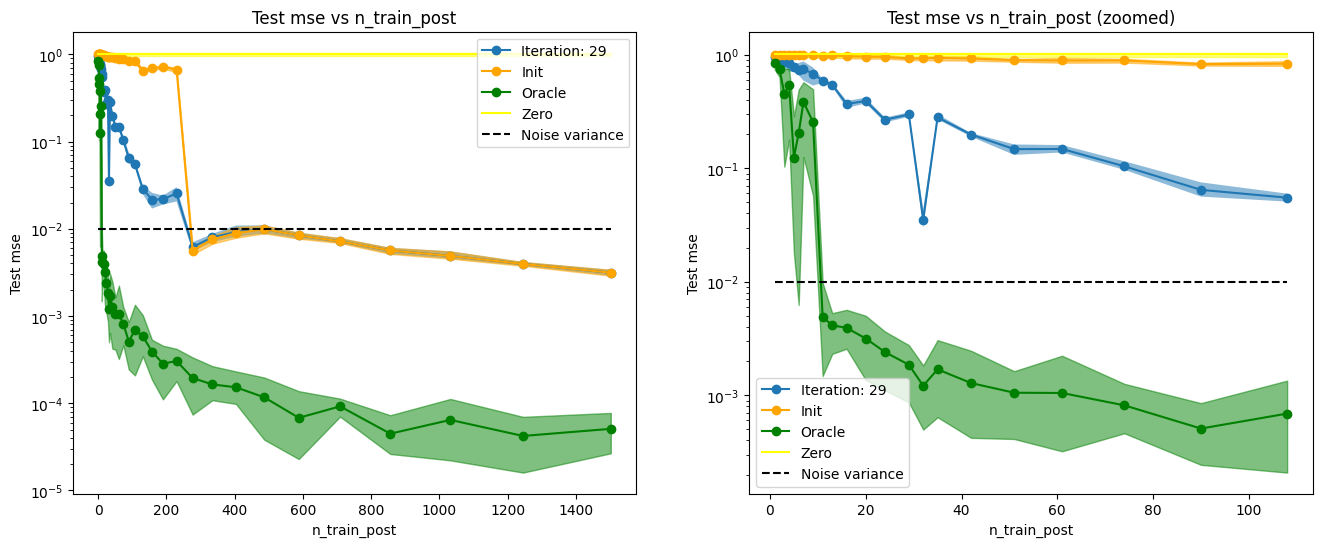

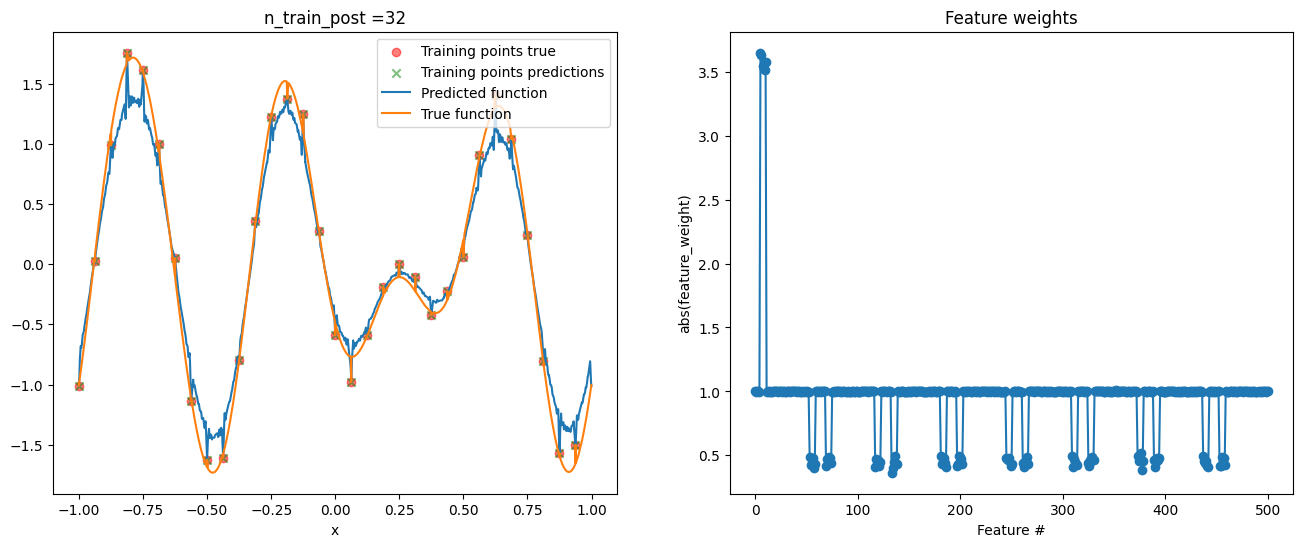

----------------------------------------------------------------------
Iteration:  40


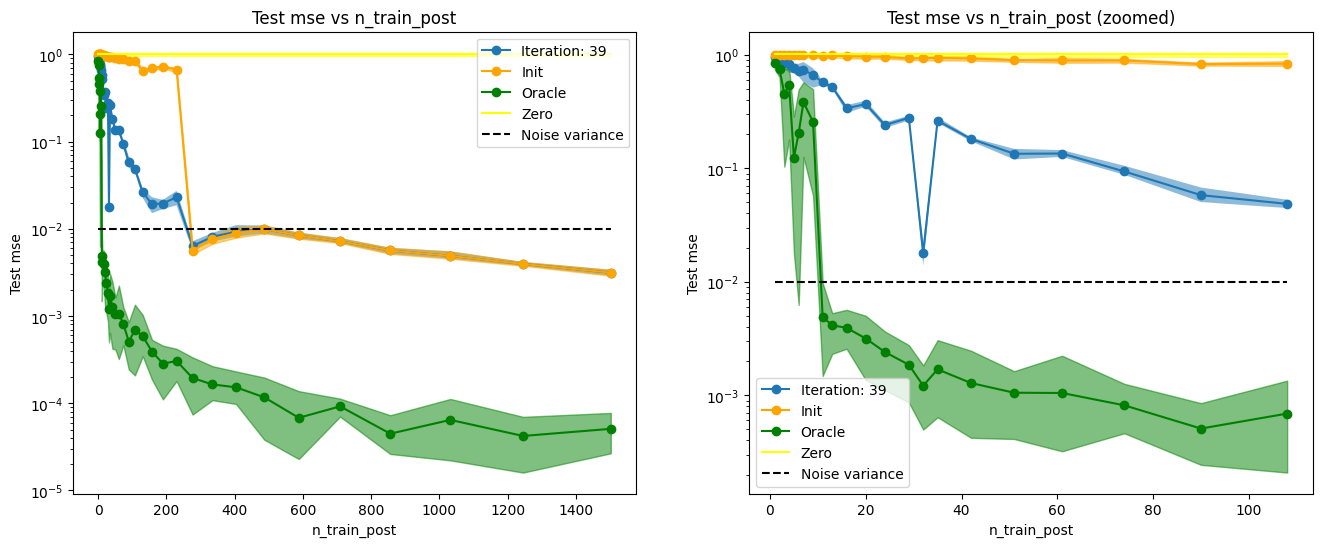

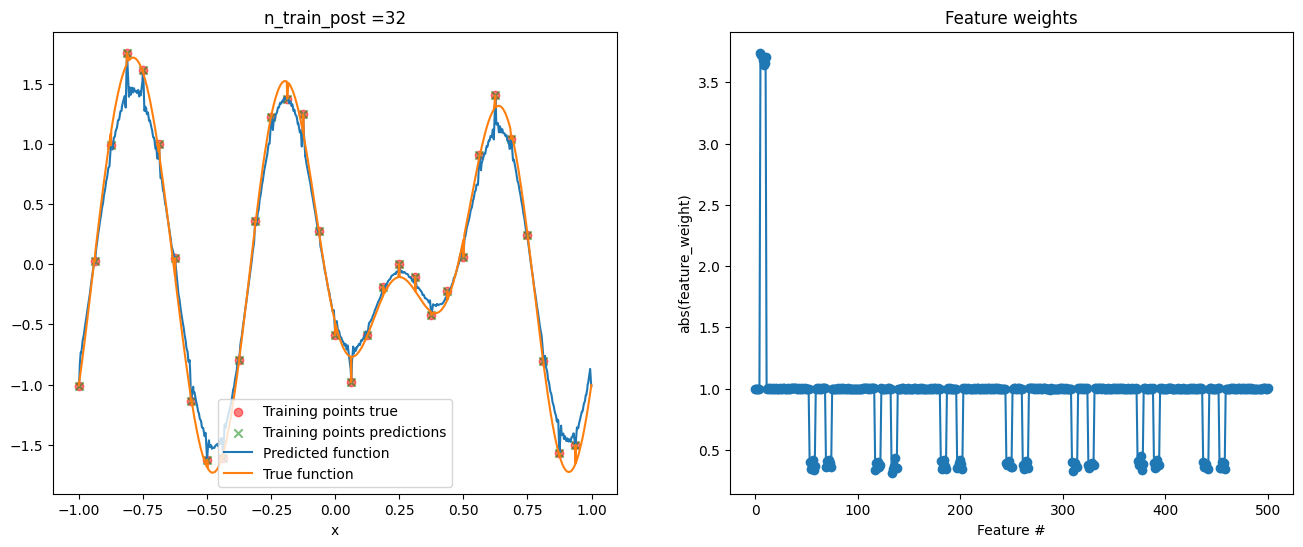

----------------------------------------------------------------------
Iteration:  50


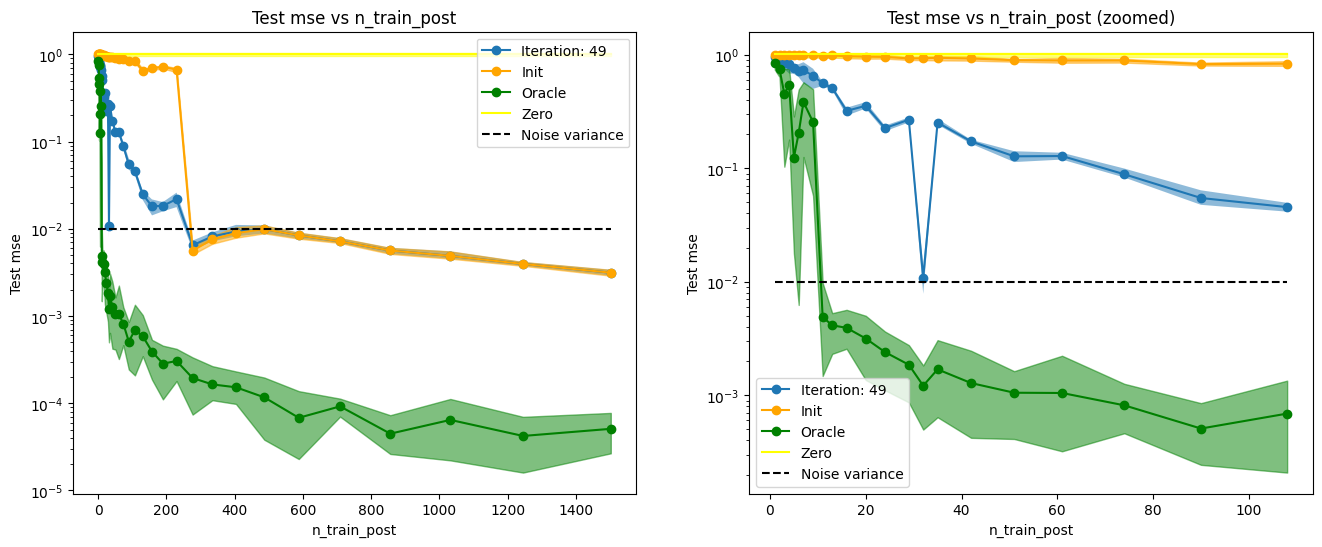

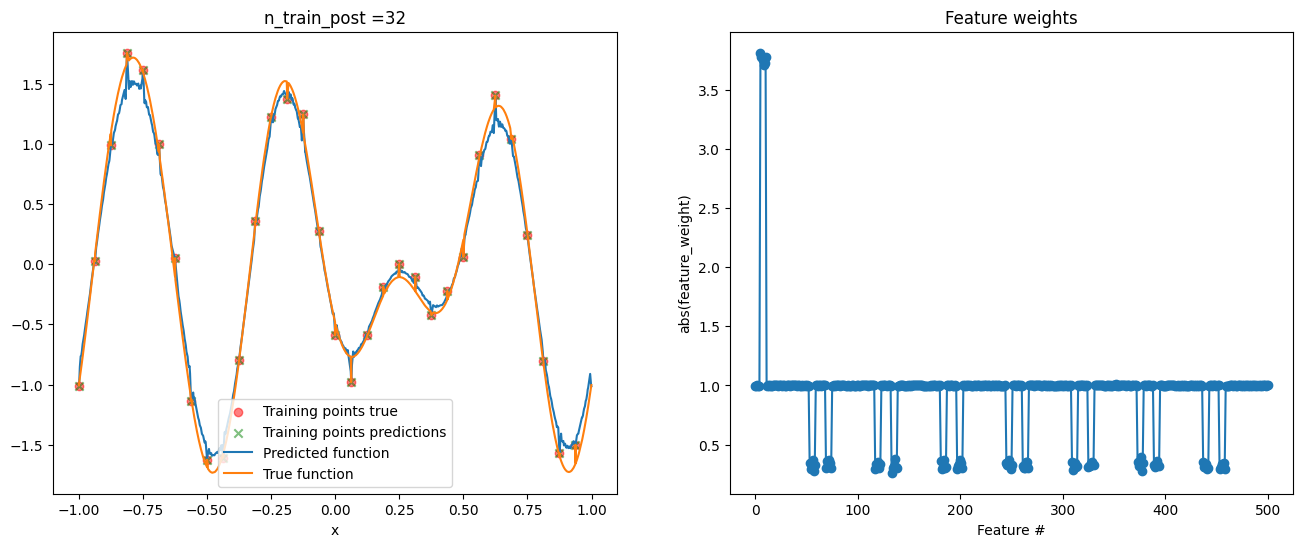

----------------------------------------------------------------------
Iteration:  60


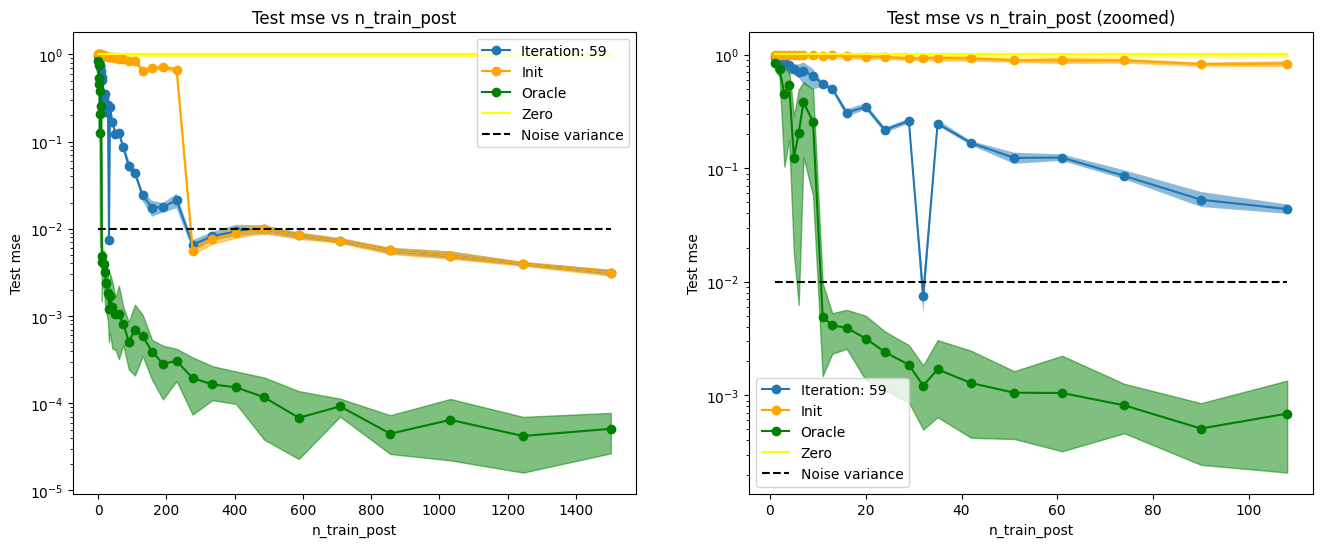

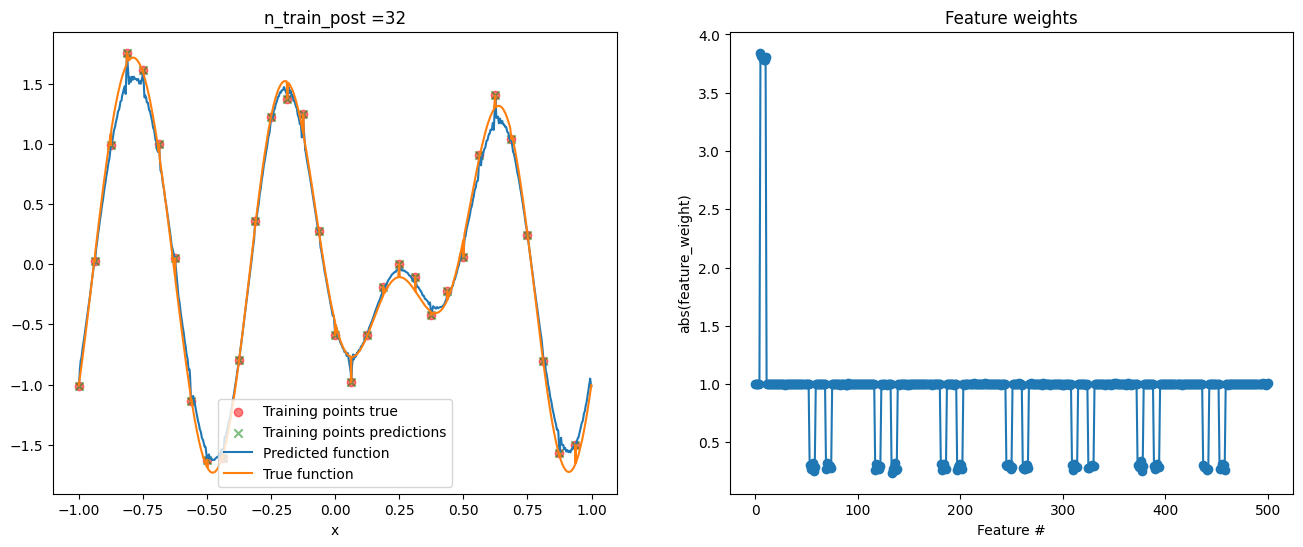

----------------------------------------------------------------------
Iteration:  70


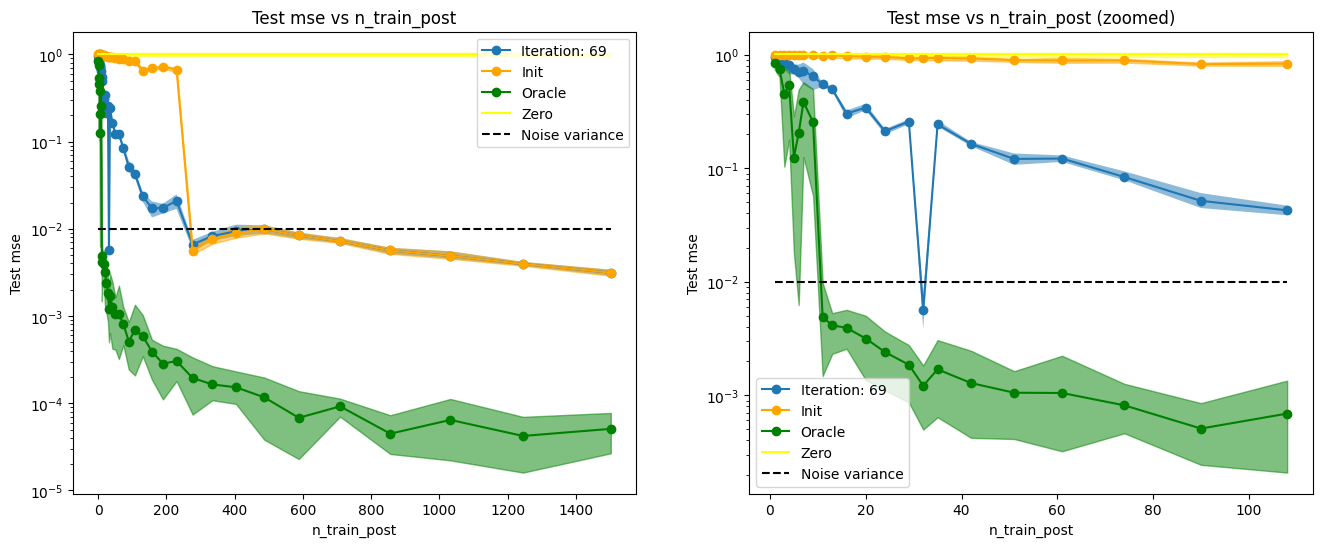

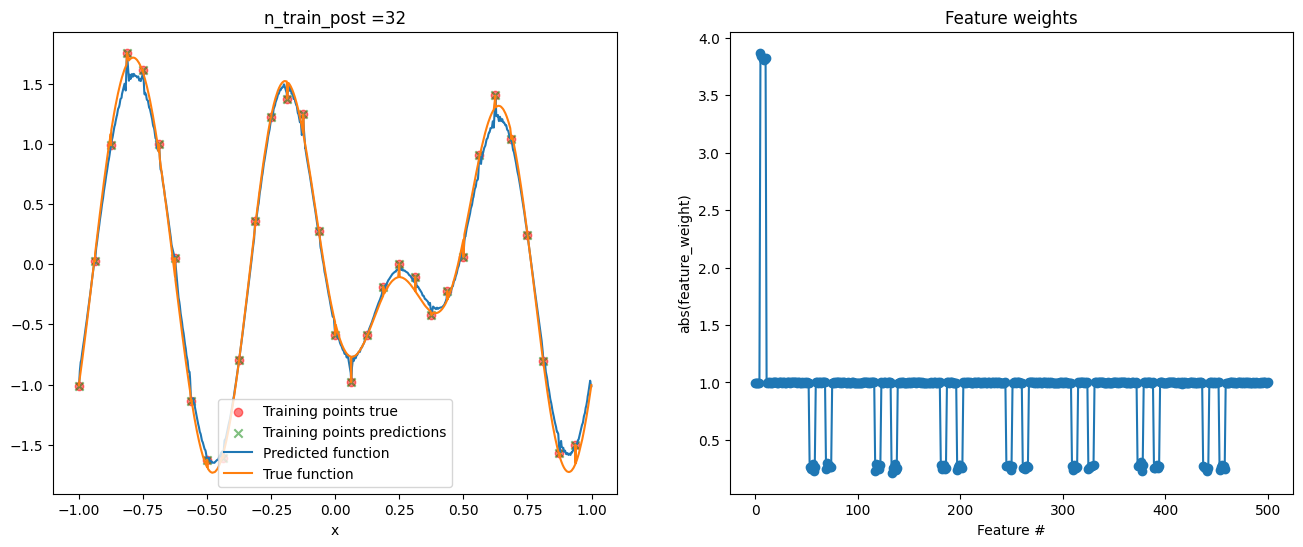

----------------------------------------------------------------------
Iteration:  80


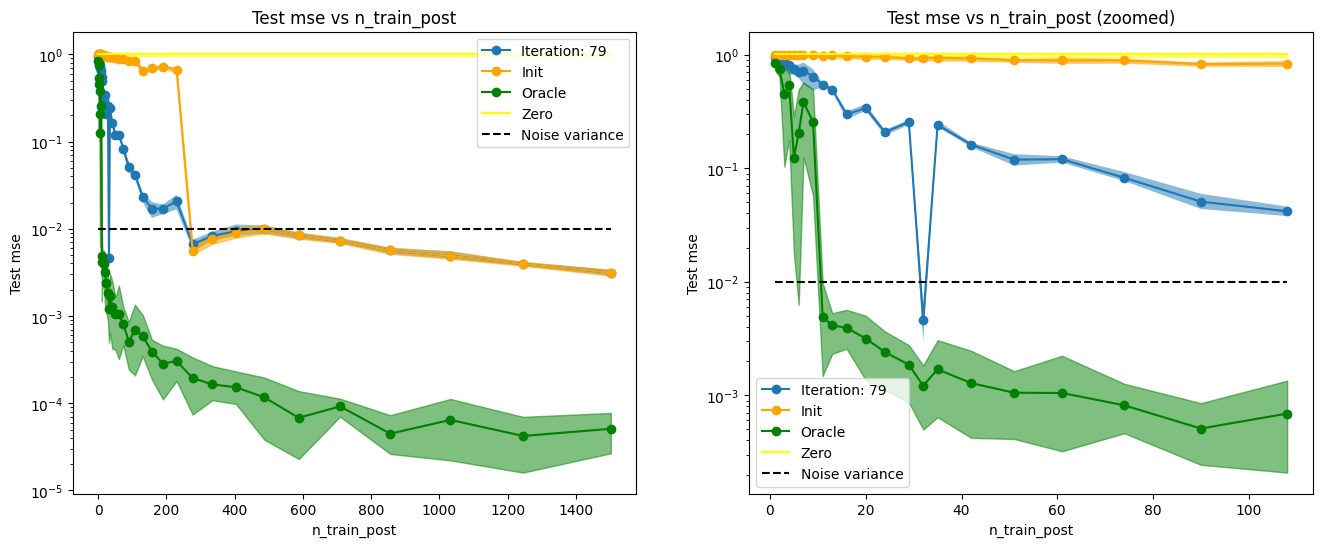

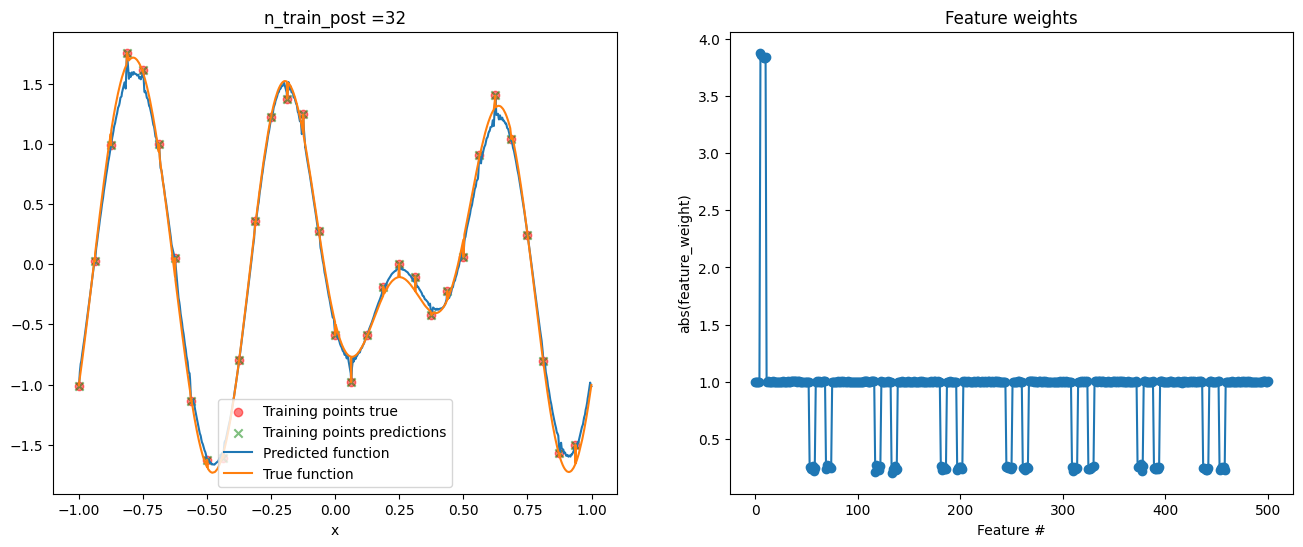

----------------------------------------------------------------------
Iteration:  90


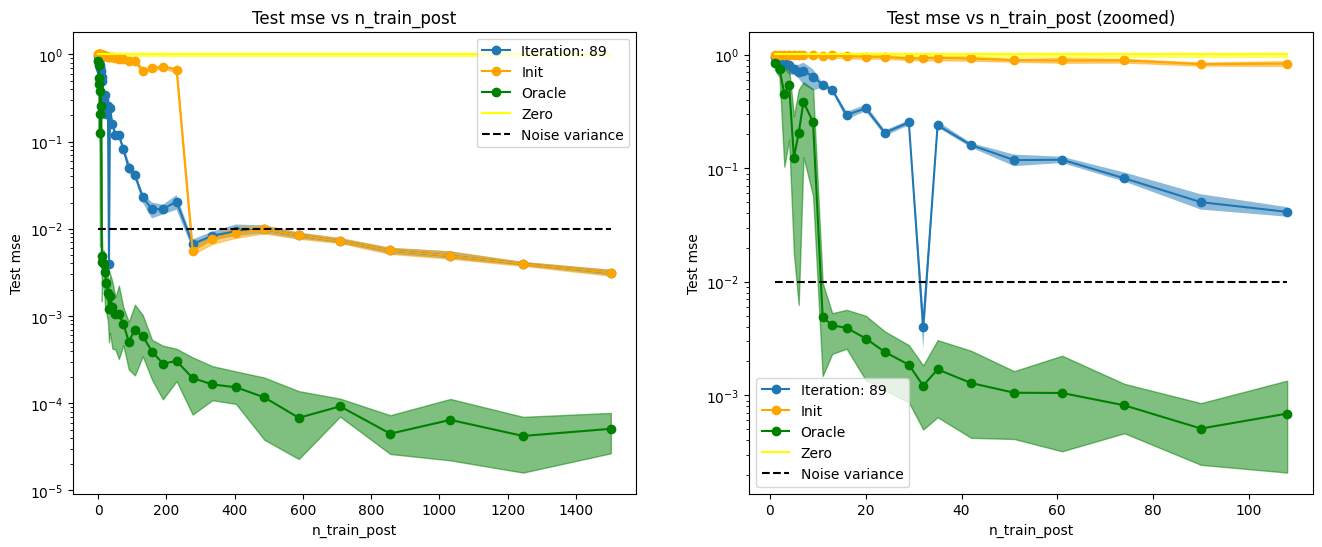

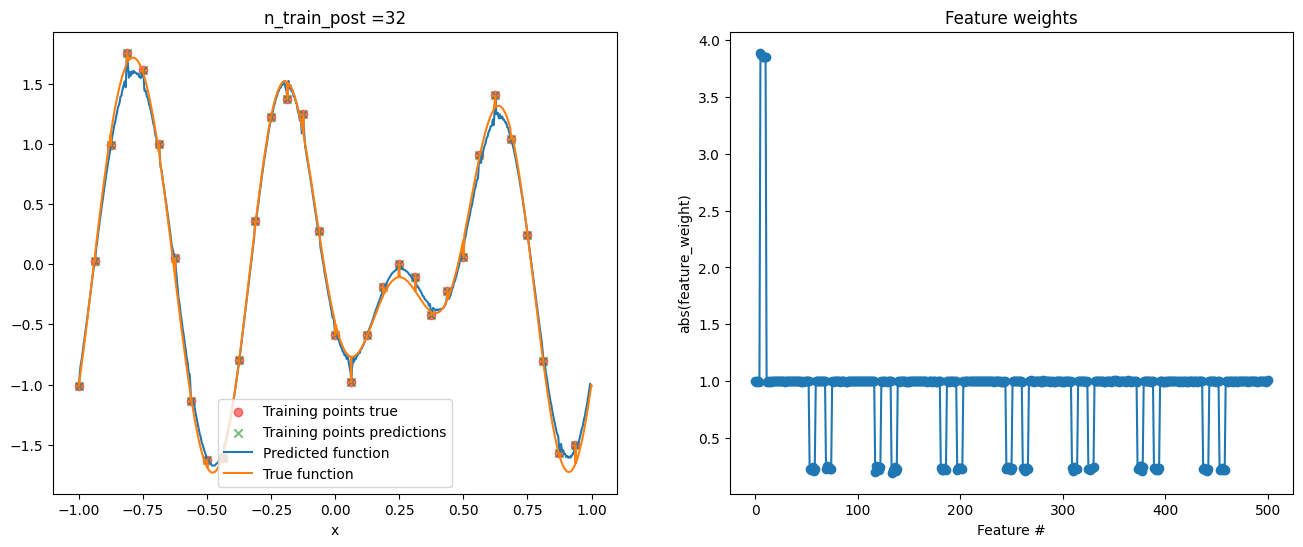

----------------------------------------------------------------------
Iteration:  100


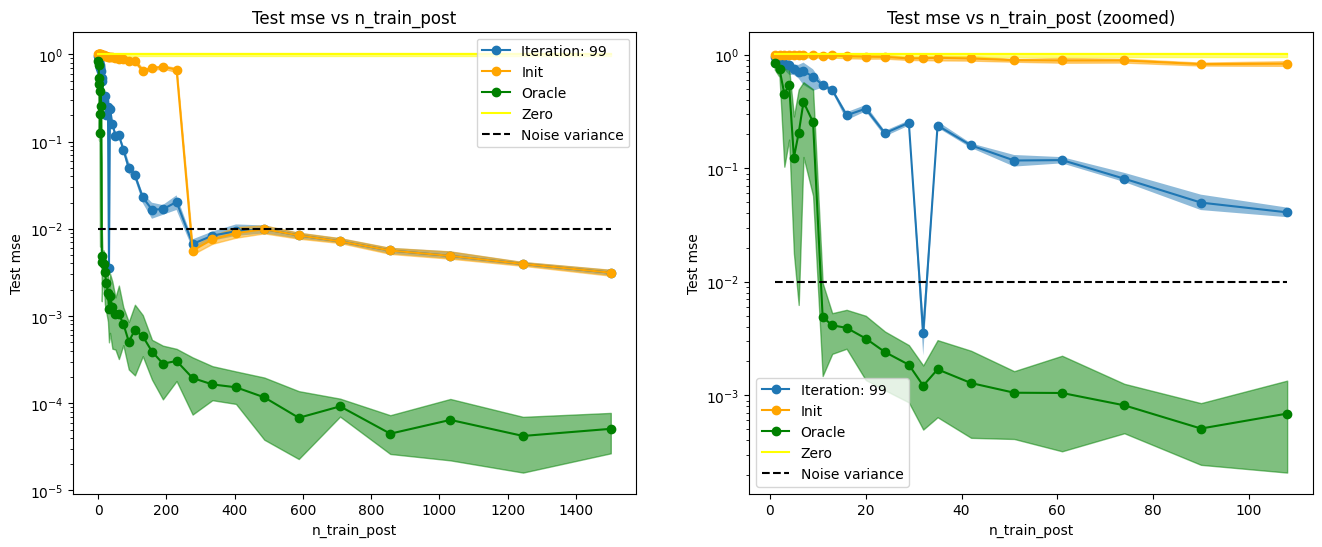

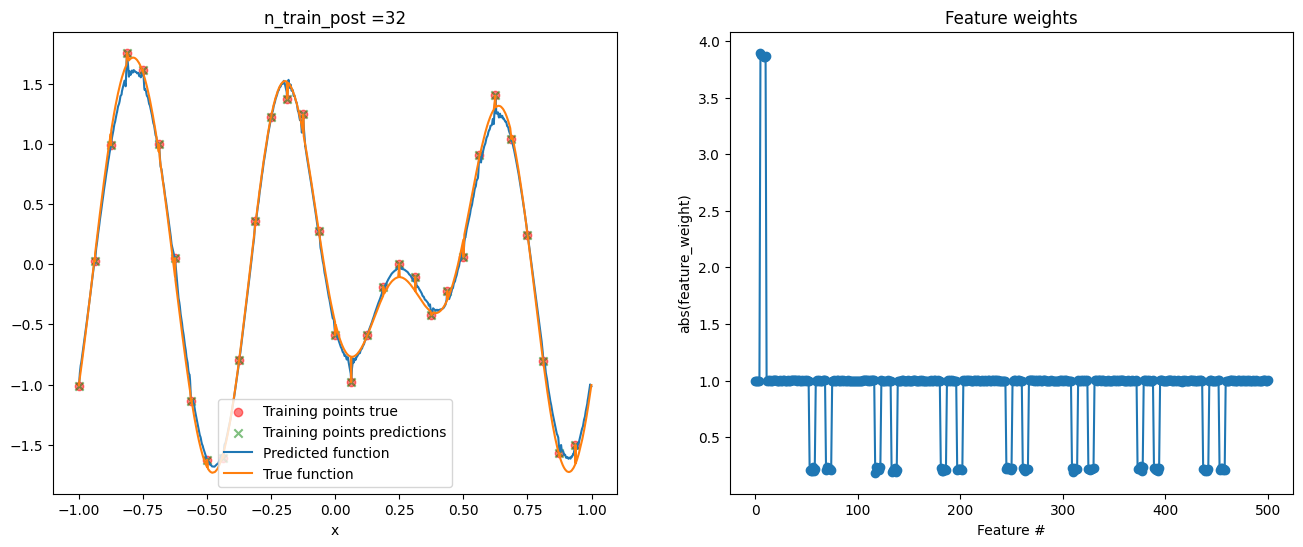

In [5]:

#Evenly spaced training points
import warnings; warnings.simplefilter('ignore')
x_type = 'grid'
params_dict = get_params_dict_reg()
cparams_dict = params_dict.copy()
cparams_dict['x_type'] = x_type   
_ = meta_learning_reg_closed_form(cparams_dict)


#### Output figures explained:

For each logged iteration, we visualize two rows of two subfigures, four in total. 

On the first row, we plot (with log scale) the test MSE loss w.r.t. the number of datapoints used for linear regression after meta training is done. The green curve plots test loss from the oracle, i.e. using only the features present in the true signal; the blue curve uses feature weights learned from doing meta training. To see how the blue curve chages as we do more iterations of meta training, we use the orange curve to mark the initial iteration-0 location of the blue curve. For each curve the solid line corresponds to the average test loss over 10 tasks, while the shaded band corresponds to the range between the 10th and 90th percentile.
The yellow line provides a baseline case,  we predict zero for each datapoint. The dashed line shows the noise variance we use when generating the data. Note how the right figure on the first row is a zoomed-in version of the figure on the left. 

On the second row, the left figure compares the true function  in orange to the predicted function in blue for one particular task. The training points and the predictions on the training points are given by the red dots and green crosses respectively. Note how these coincide since we are in the overparaamterized regime and are able to interpolate the training data.

The figure on the right shows the learned feature weights as meta training progresses. Note how all of the 500 features were equally weighted with 1 at the beginning.

## Replacing closed form solution with GD

In the previous parts we saw how we could use the closed form solution to min norm least squares to train our meta learning parameter (the feature weights). However for most problems we will not have closed form solutions to the task that we wish to solve. In the absence of this, we must resort to iterative methods such as gradient descent. For the regression task, we can perform gradient descent on the squared loss. However we need to ensure that the process of computing the coefficients during inner training we preserve gradients with respect to the feature weights. Pytorch allows us to do this with the help of the higher module.

### (f) Run the next three cells and answer the following questions:

1. With num_gd_steps = 5 does meta-learning help improve performance during test time? What happens if instead we use num_gd_steps = 1. Does meta-learning still work?

Note that in these experiments we use gradient descent in the inner loop for num_gd_steps but while testing our performance we use the closed form expression for the min norm least squares solution. This is because while testing final performance we must either run enough iterations of gradient descent to get sufficiently close to the closed form solution or use the closed form solution. However we will see that while doing the meta training even 1 gradient descent step towards the solution helps us learn the feature weights. 

In [6]:
from utils_reg import  meta_learning_reg_sgd
def get_params_dict_reg_sgd():
    params_dict = {
        #Parameters
    'seed':7,
    'n_train_inner':32, #Number of training samples for training inner task
    'n_train_meta':64, #Number of training samples for updating the meta parameter

    'n_train_post':32, #Number of training samples used after meta training has been done to learn the weights
    'n_test_post':1000, #Number of samples used for plotting and evaluating test performance after meta training has been done 

    'x_type':'uniform_random', #sampling time for inner and post training tasks
    # 'x_type':'grid', #sampling time for training tasks

    'd':501, #Number of features
    'phi_type':'fourier', #Feature type
     'noise_std':1e-1, #standard deviation of awgn noise added during training 
    'optimizer_type':'SGD', #Optimizer type for meta updates Can be either SGD or Adam
    'k_idx':np.arange(5,11), #Frequency range present in tasks during meta training
    'stepsize_meta':1e-2, #Stepsize used for meta updates

     'num_inner_tasks':5, #Number of inner tasks for each meta update   
    'num_tasks_test':10, #Number of tasks to test on
    'num_stats': 10, #Determines how often we collect stats

    'num_iterations':100, #Iterations for training meta parameter
        'num_n_train_post_range':40, #How many points do we use to generative test loss vs n_train_post curve


    'stepsize_inner':1e-2, #Stepsize for GD update in inner tasks,
    'num_gd_steps':5, #Number of GD steps in inner task to move towards min norm ls solution

    }
    return params_dict



----------------------------------------------------------------------
Iteration:  0


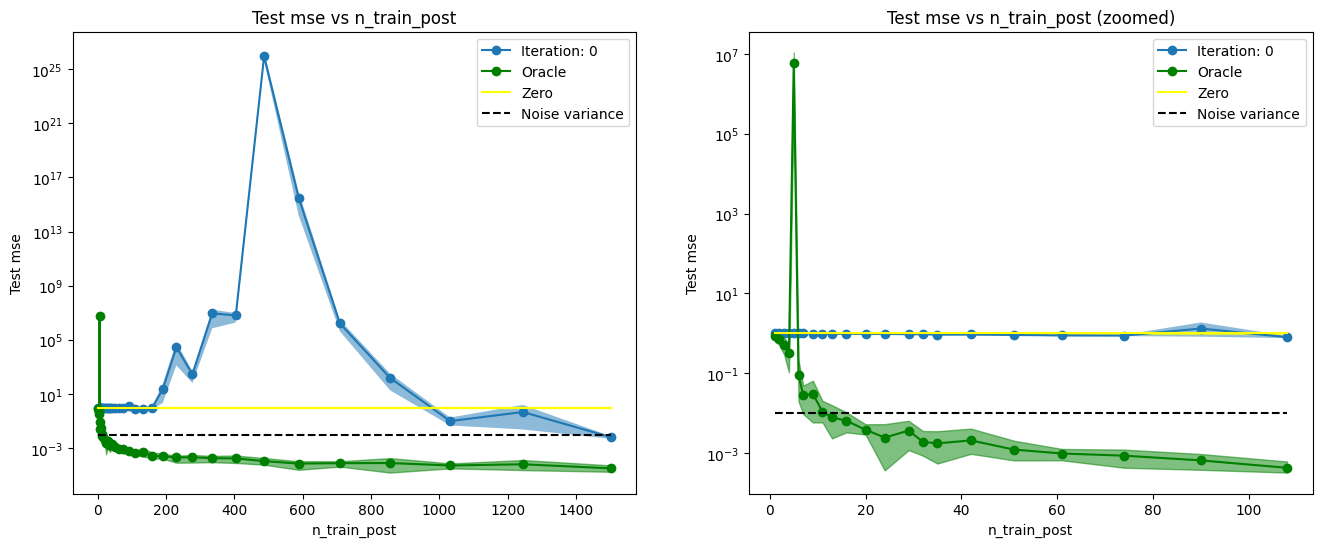

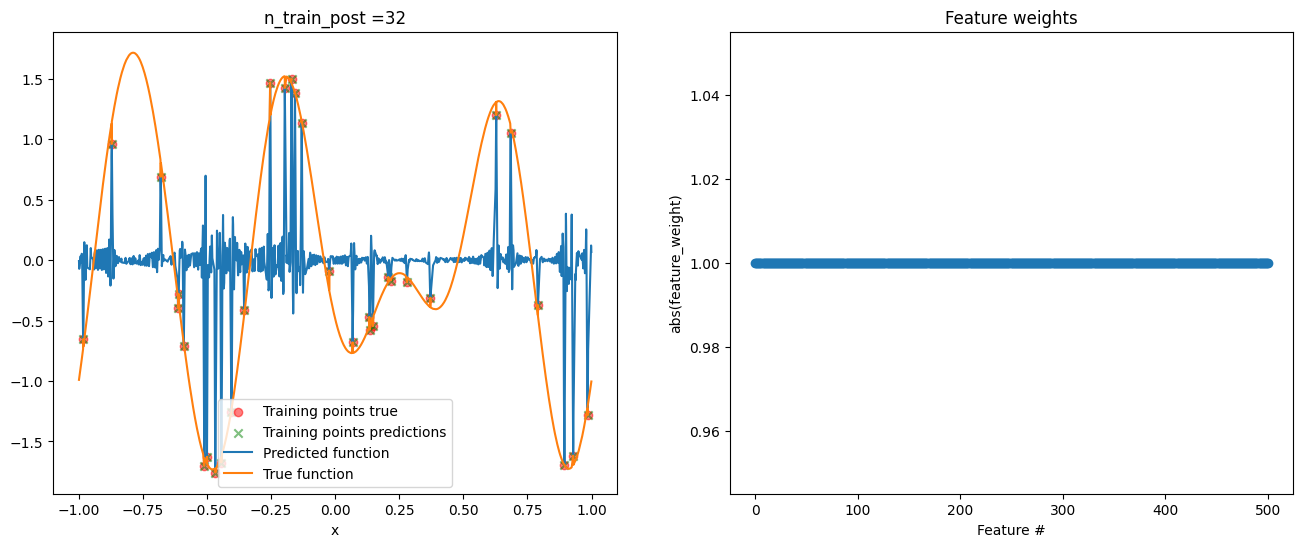

----------------------------------------------------------------------
Iteration:  10


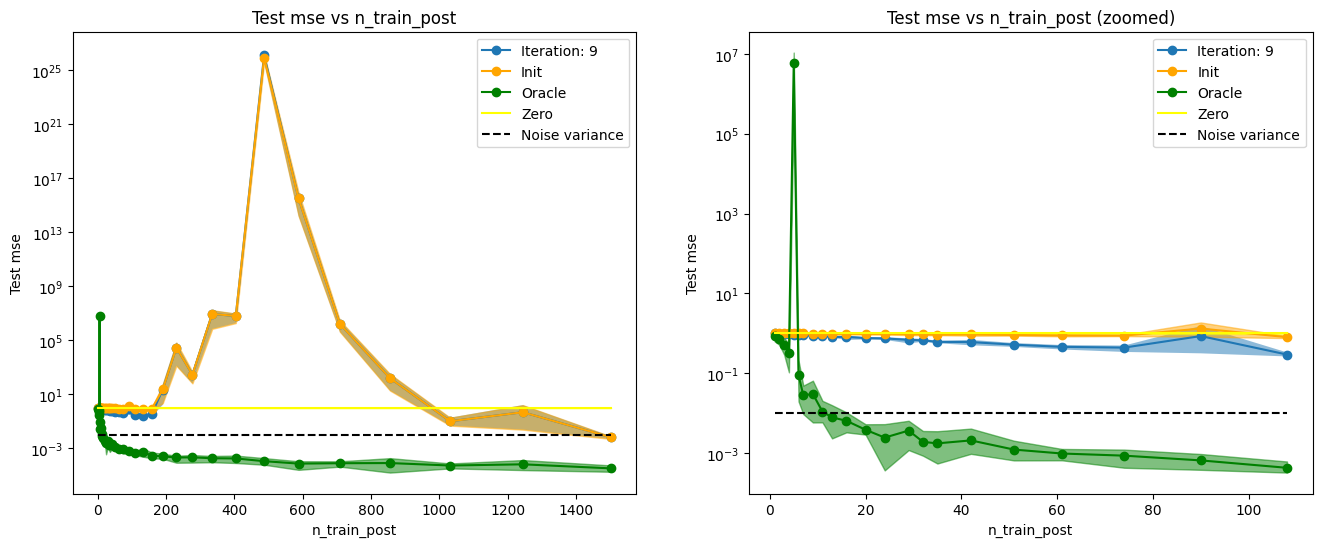

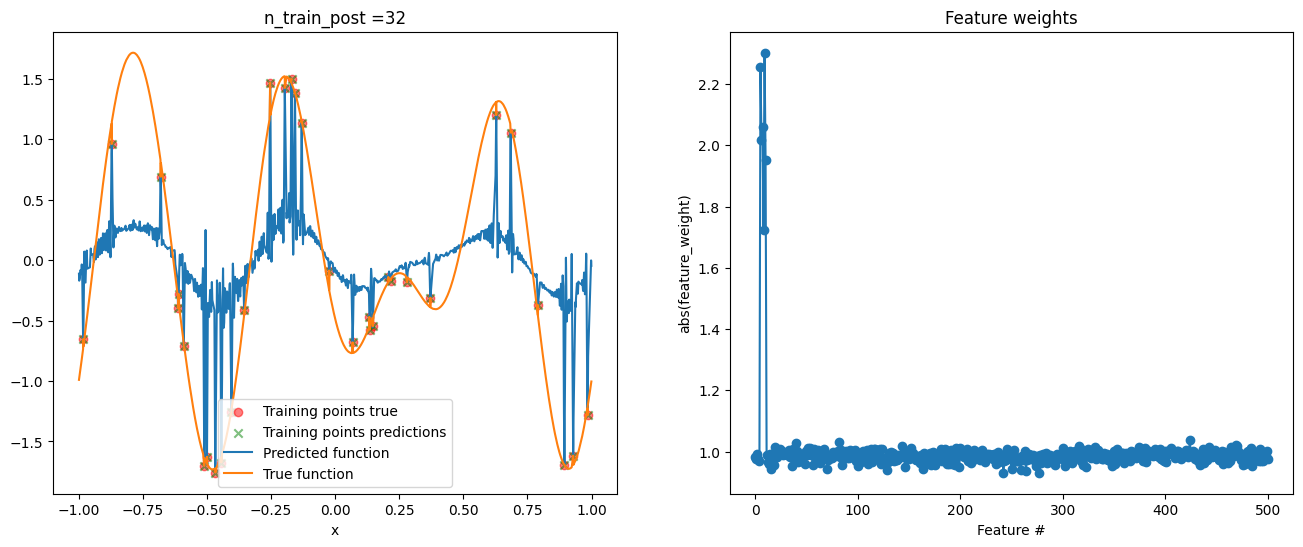

----------------------------------------------------------------------
Iteration:  20


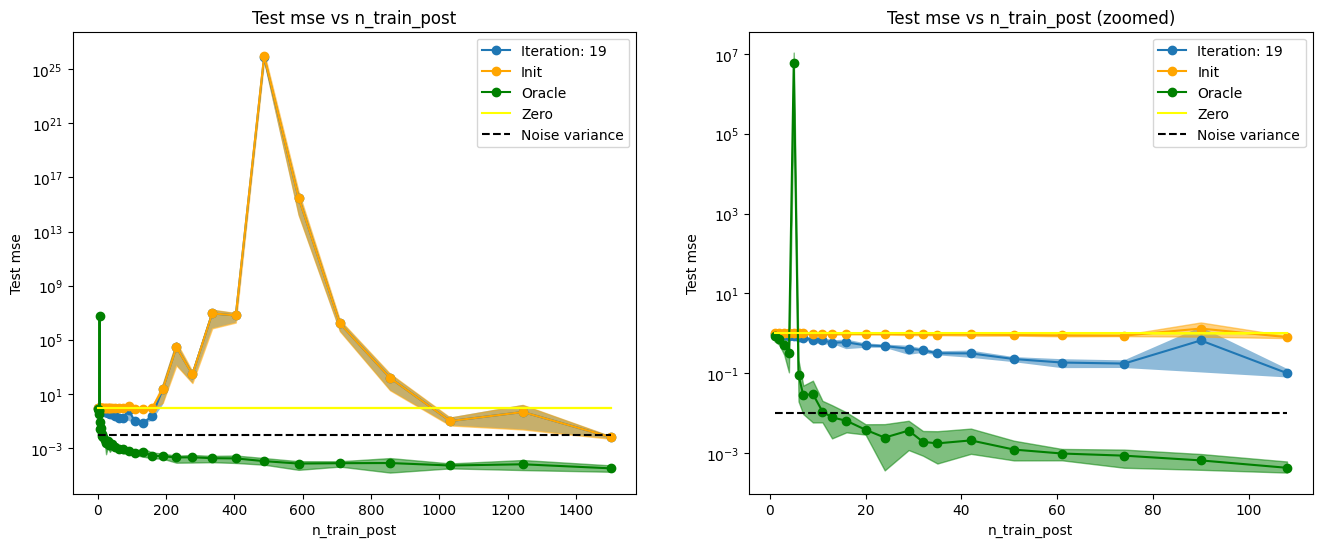

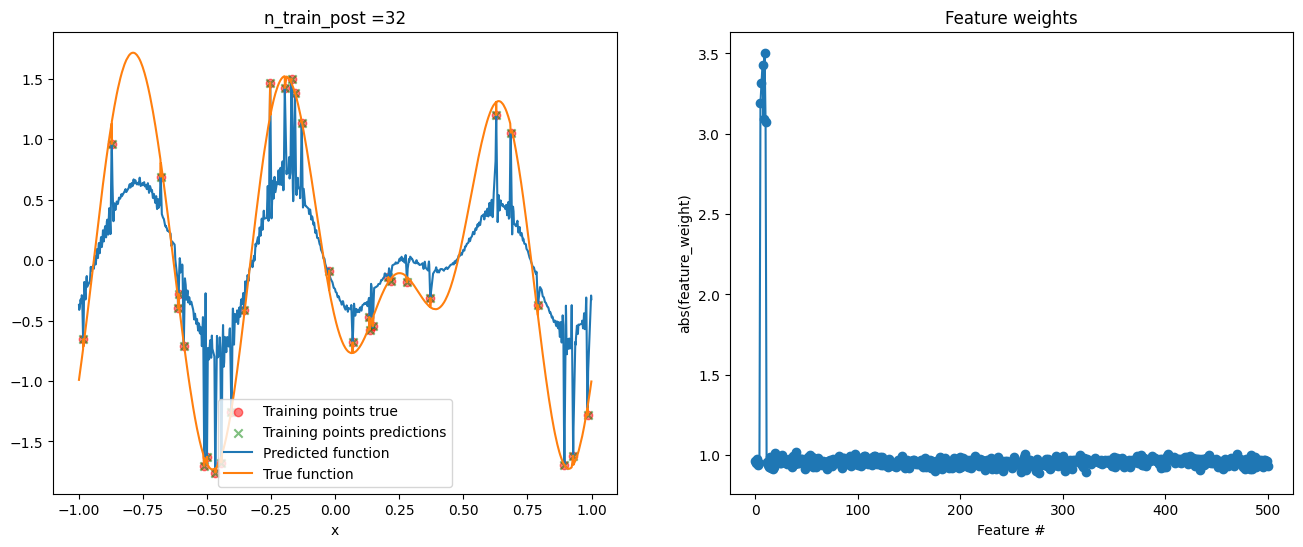

----------------------------------------------------------------------
Iteration:  30


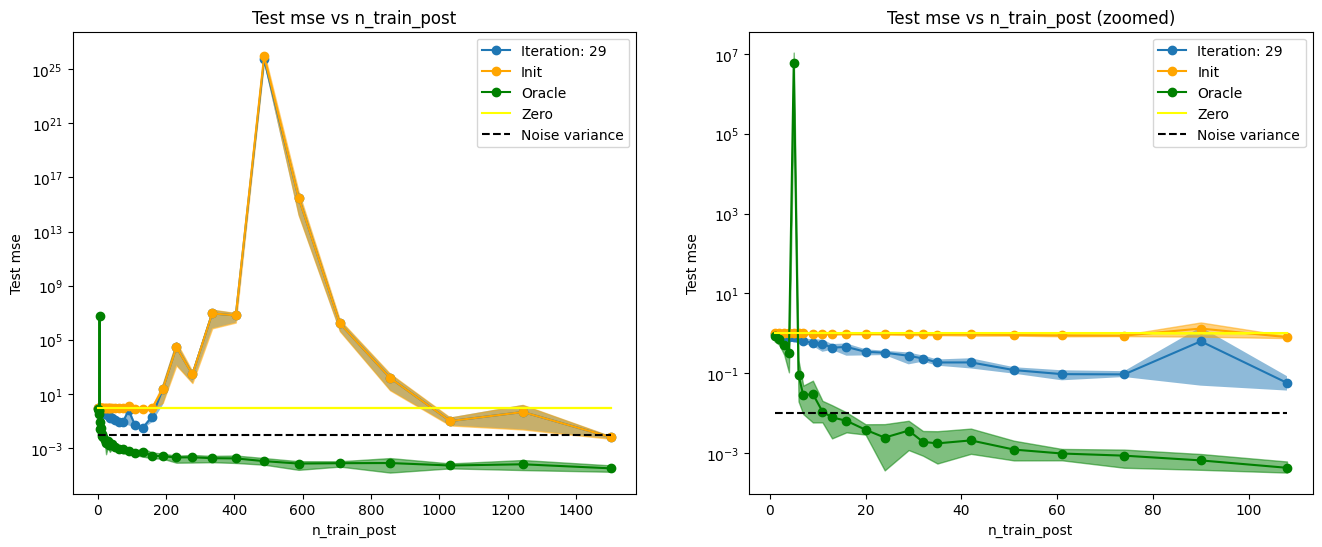

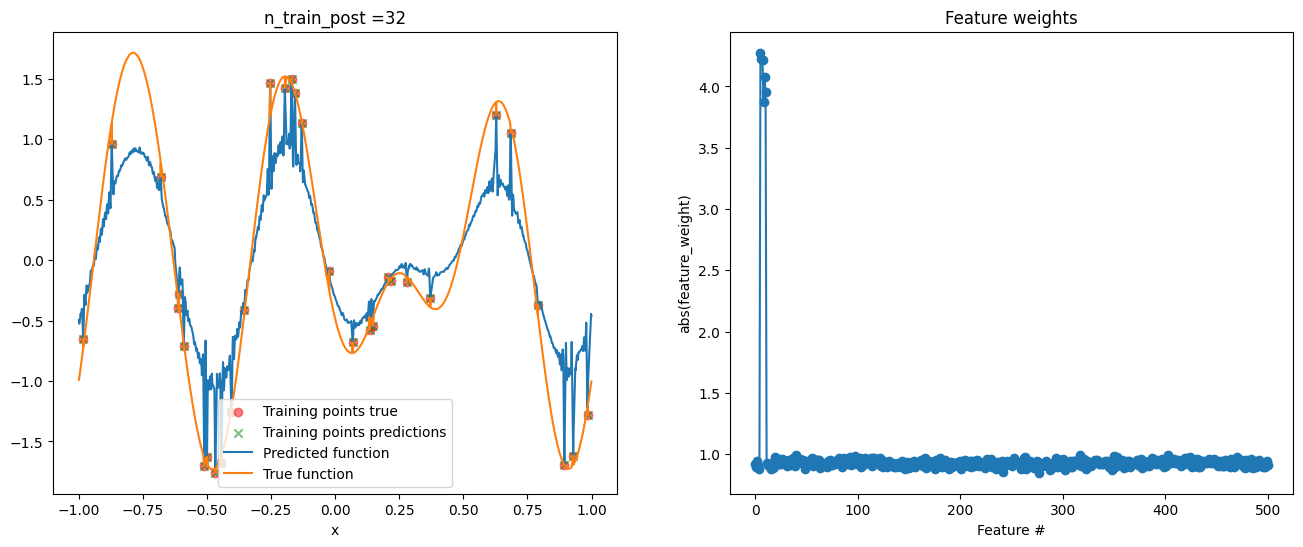

----------------------------------------------------------------------
Iteration:  40


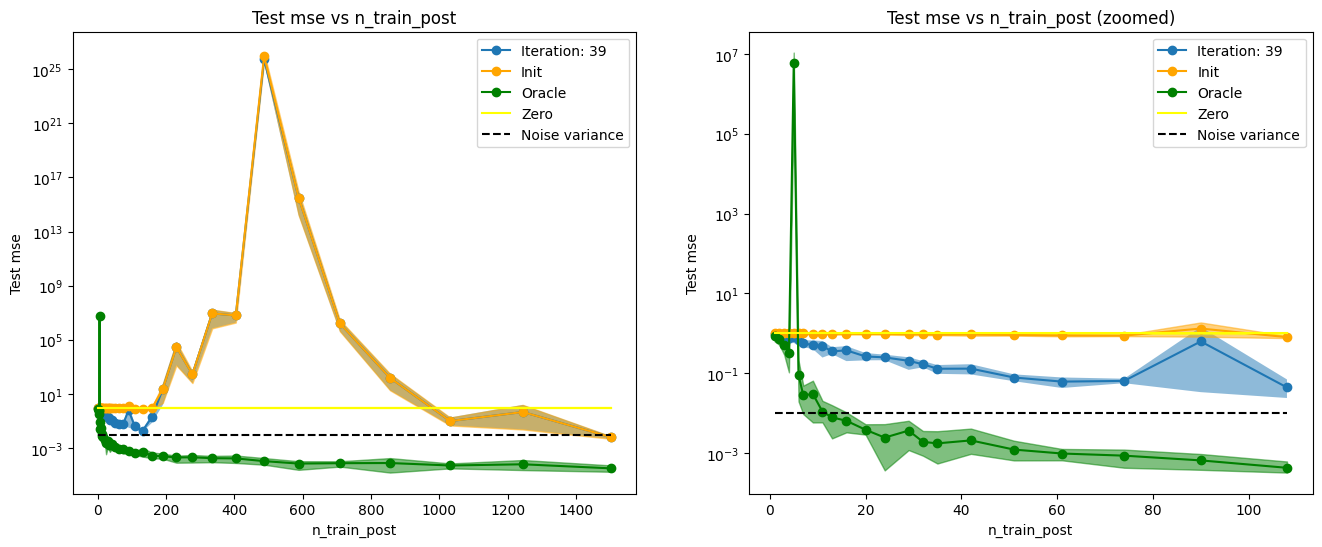

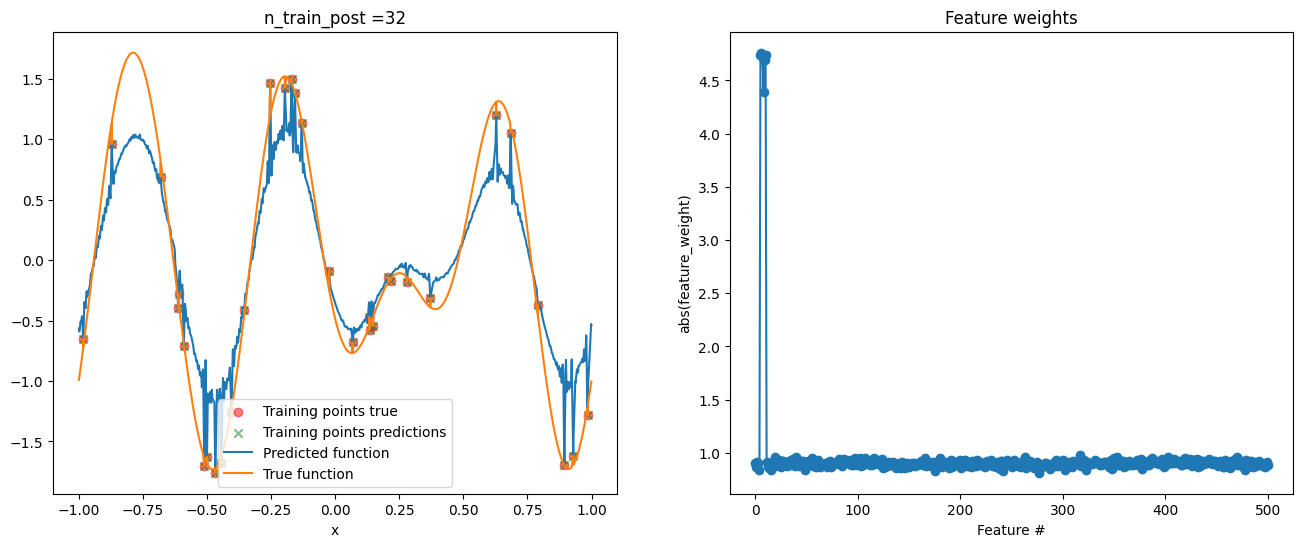

----------------------------------------------------------------------
Iteration:  50


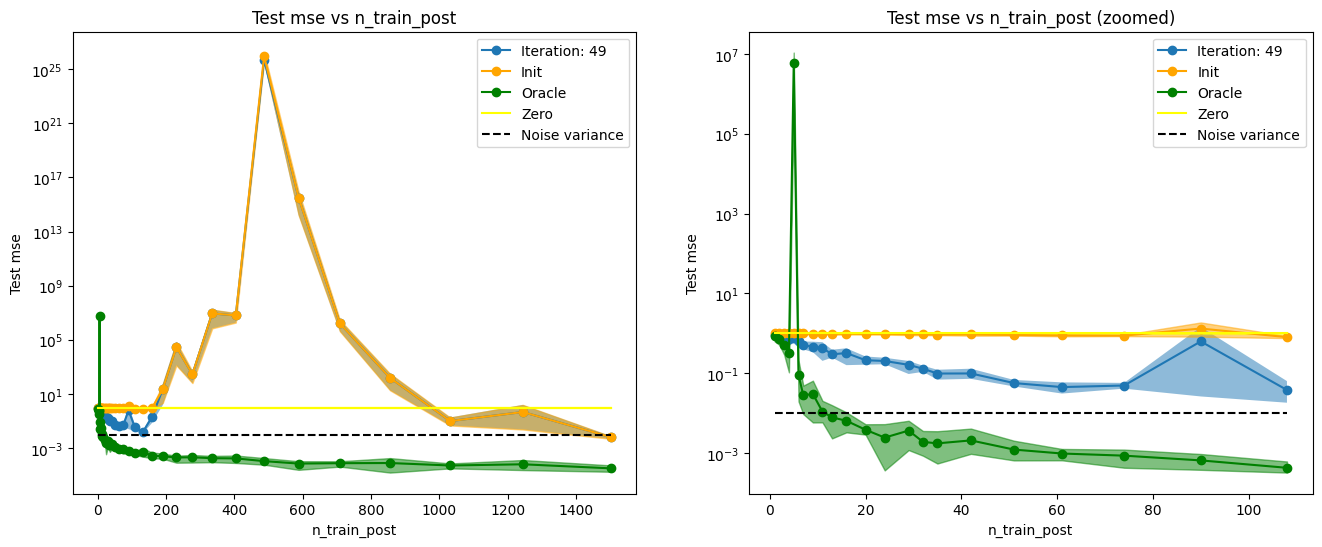

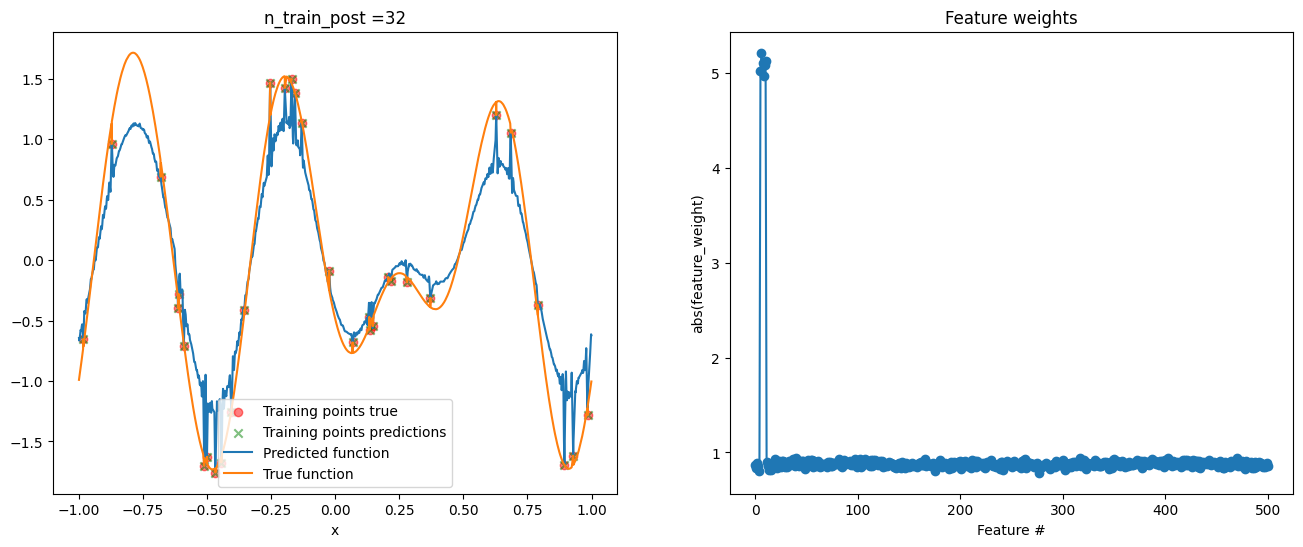

----------------------------------------------------------------------
Iteration:  60


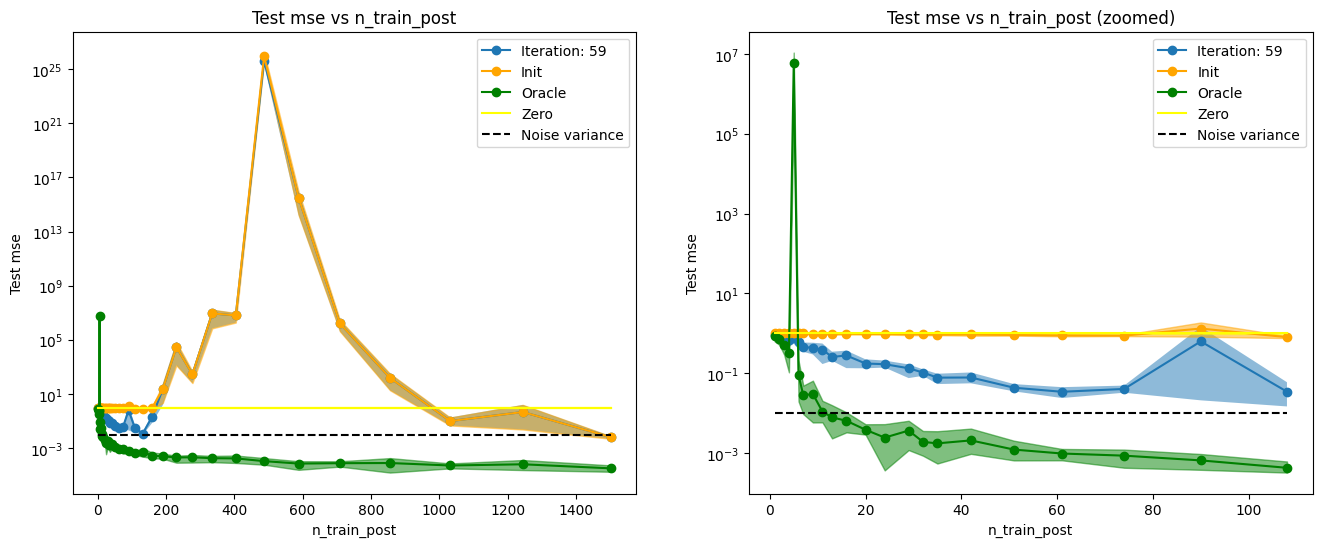

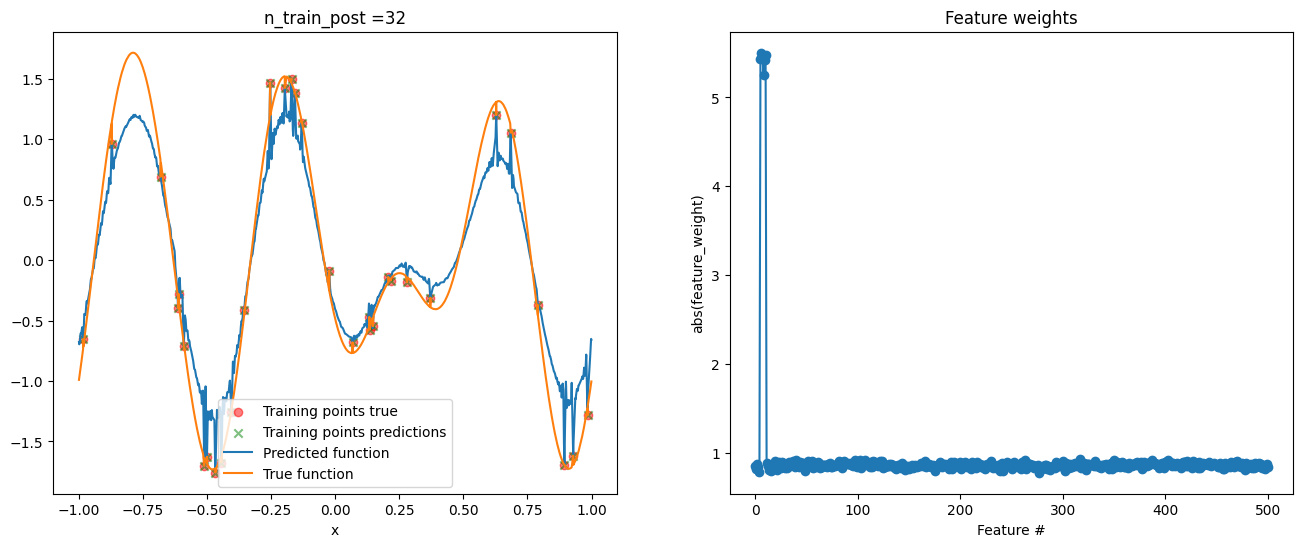

----------------------------------------------------------------------
Iteration:  70


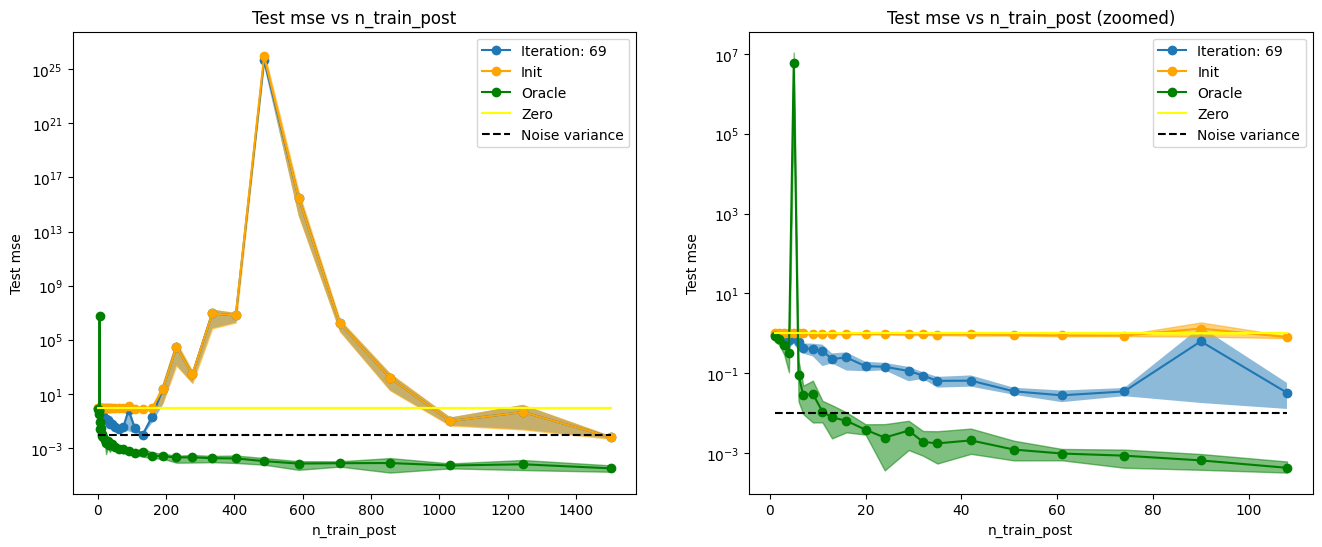

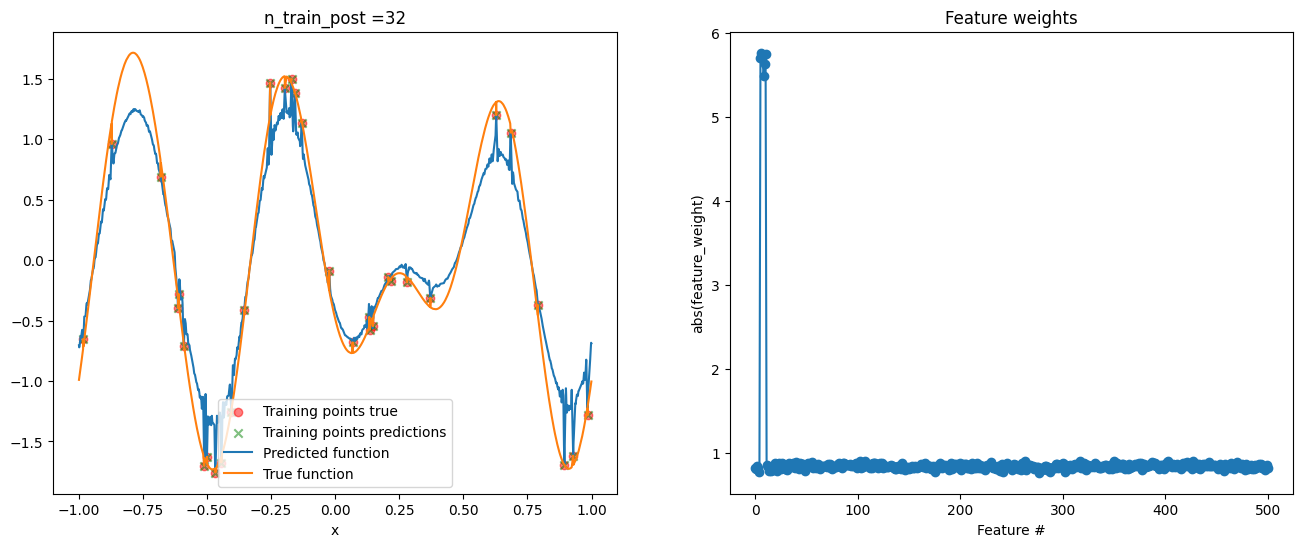

----------------------------------------------------------------------
Iteration:  80


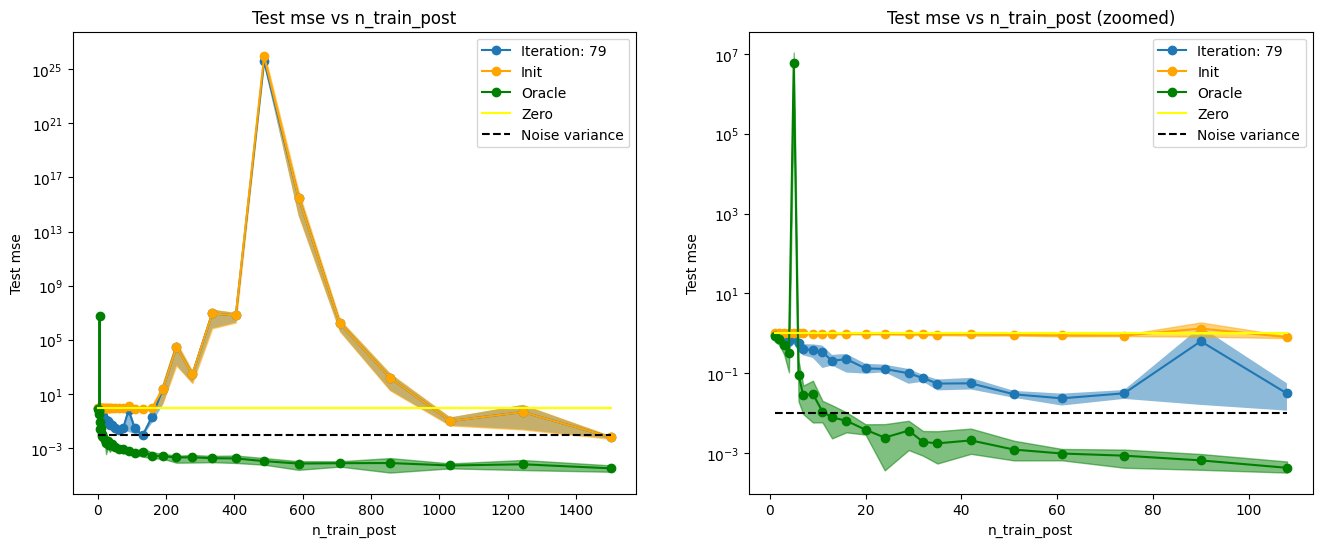

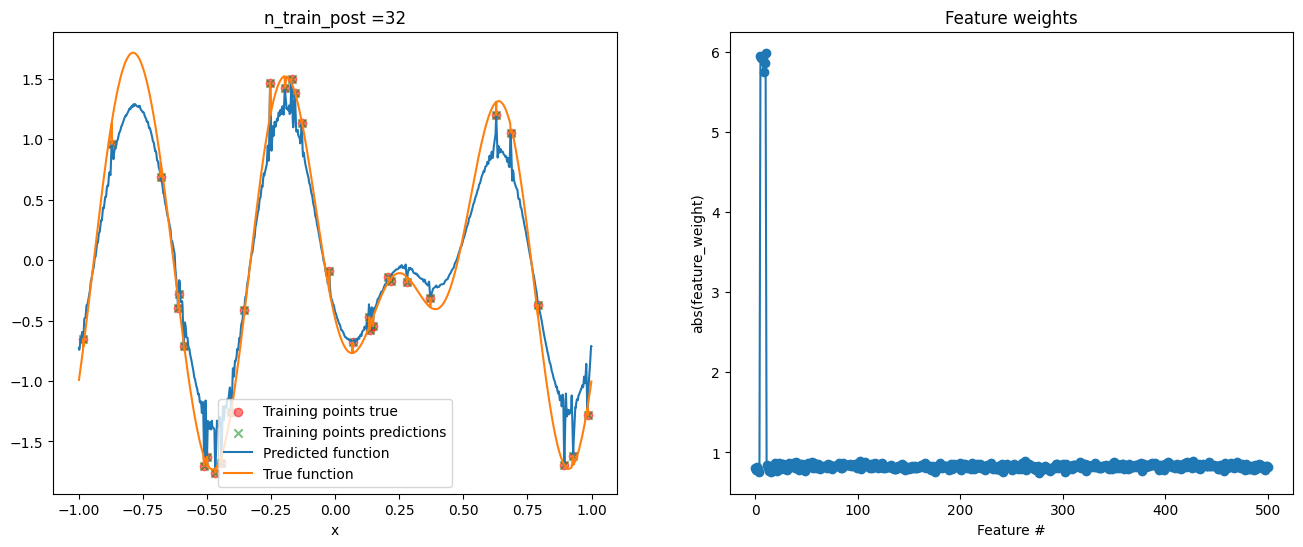

----------------------------------------------------------------------
Iteration:  90


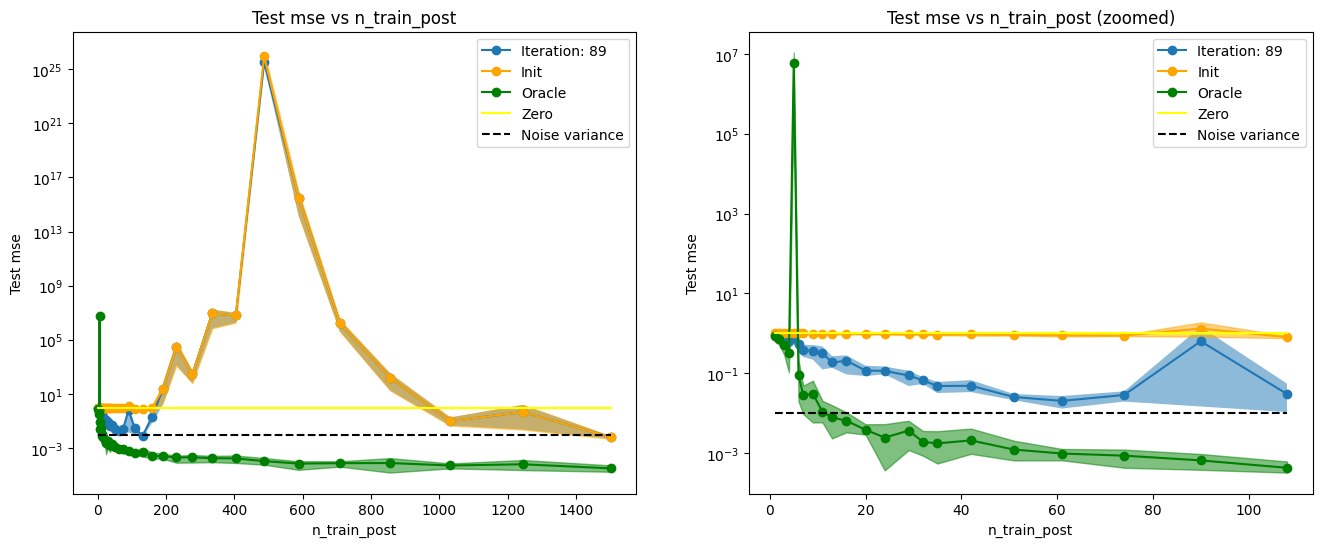

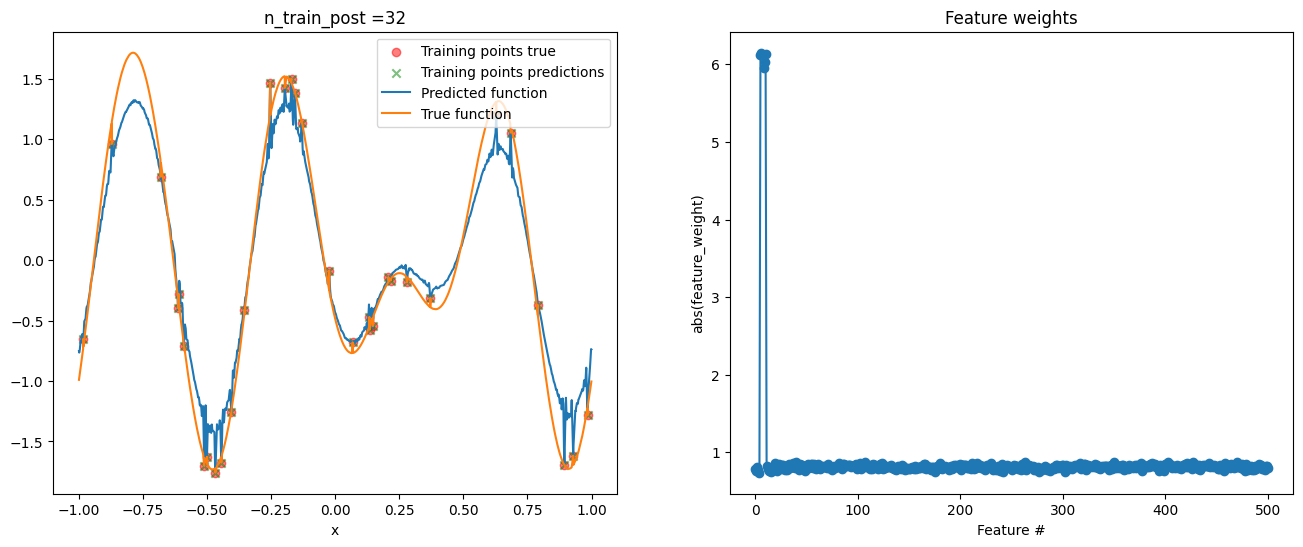

----------------------------------------------------------------------
Iteration:  100


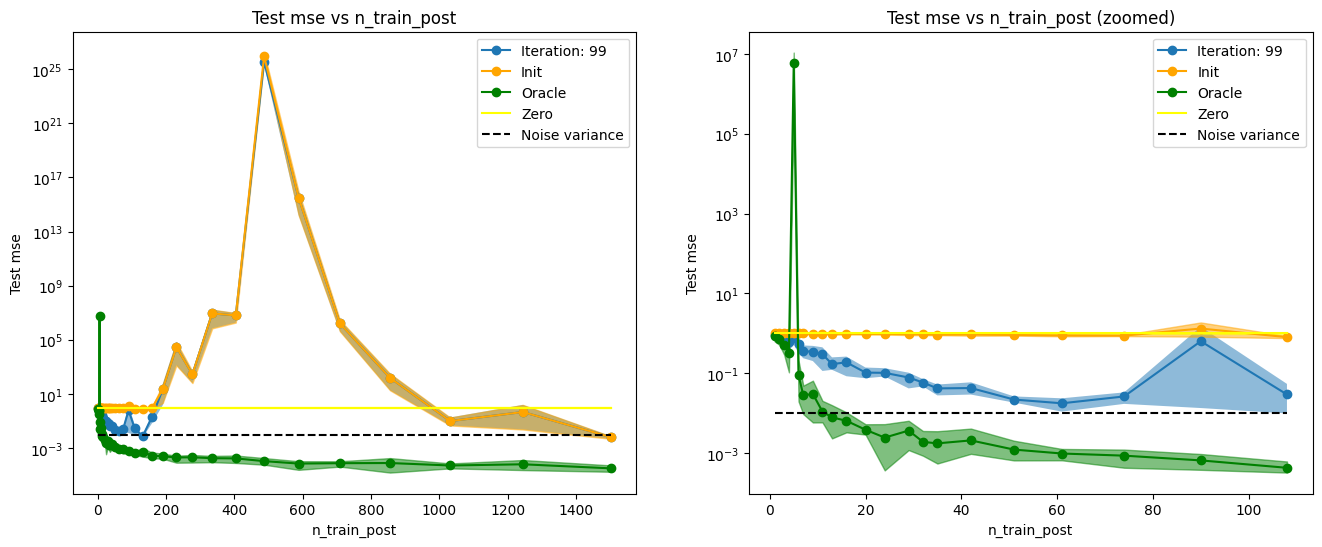

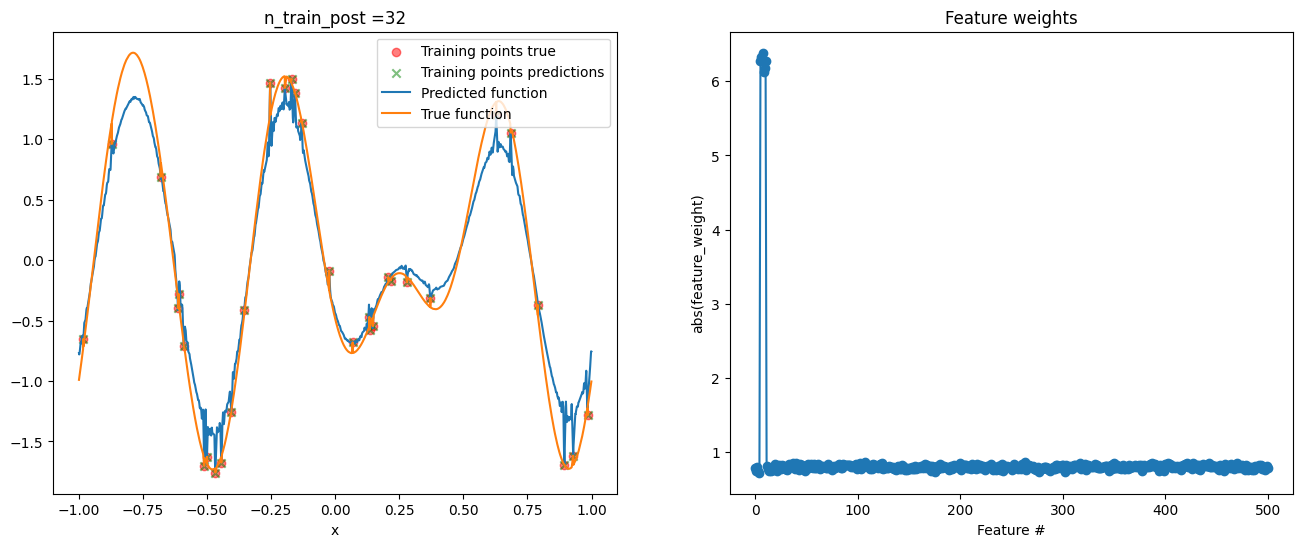

In [7]:
params_dict = get_params_dict_reg_sgd()
num_gd_steps = 5
cparams_dict = params_dict.copy()
cparams_dict['num_gd_steps'] = num_gd_steps

meta_learning_reg_sgd(cparams_dict)

----------------------------------------------------------------------
Iteration:  0


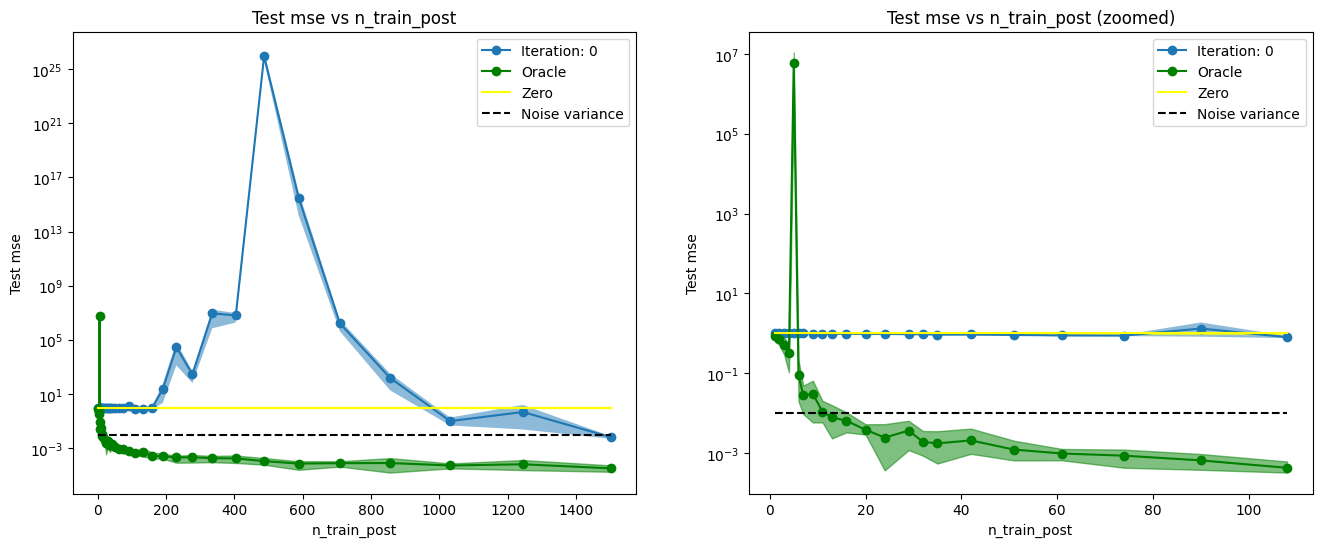

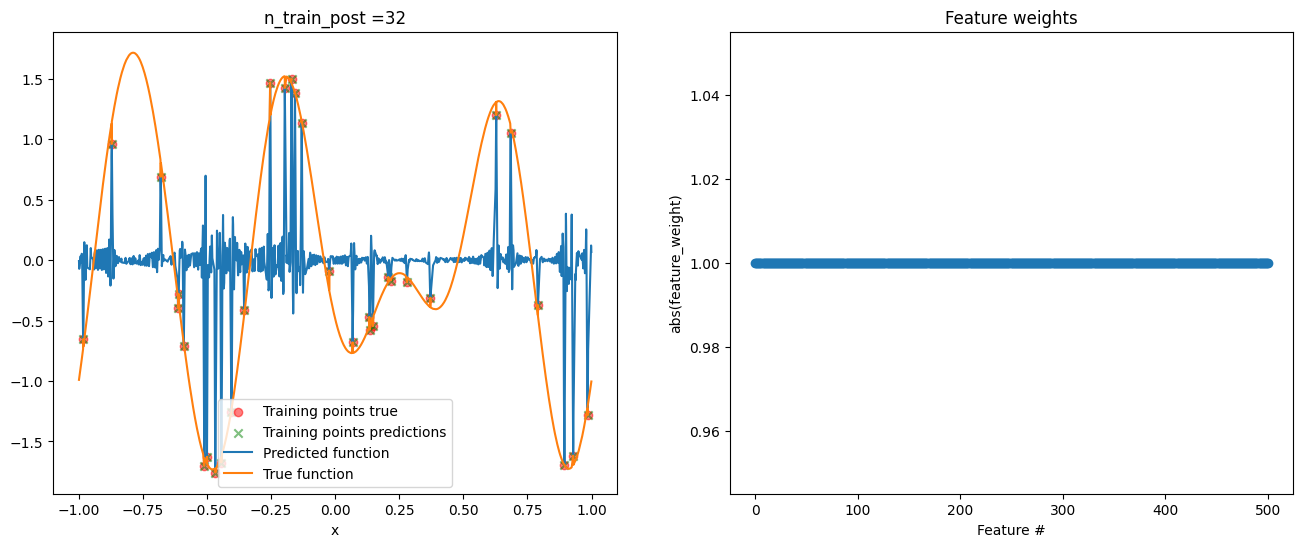

----------------------------------------------------------------------
Iteration:  10


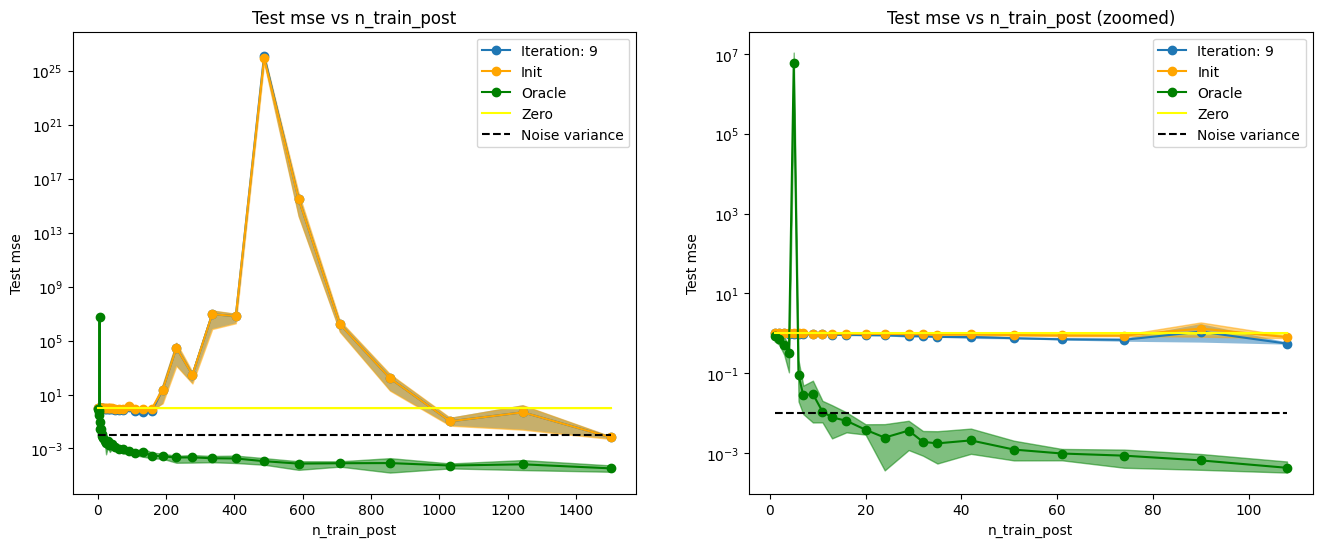

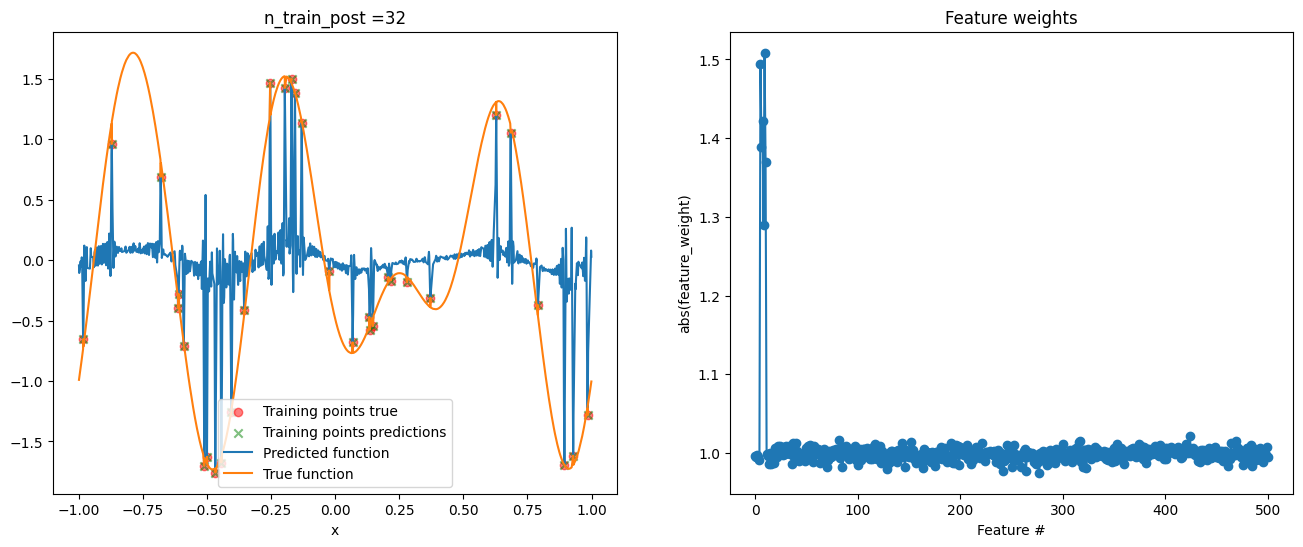

----------------------------------------------------------------------
Iteration:  20


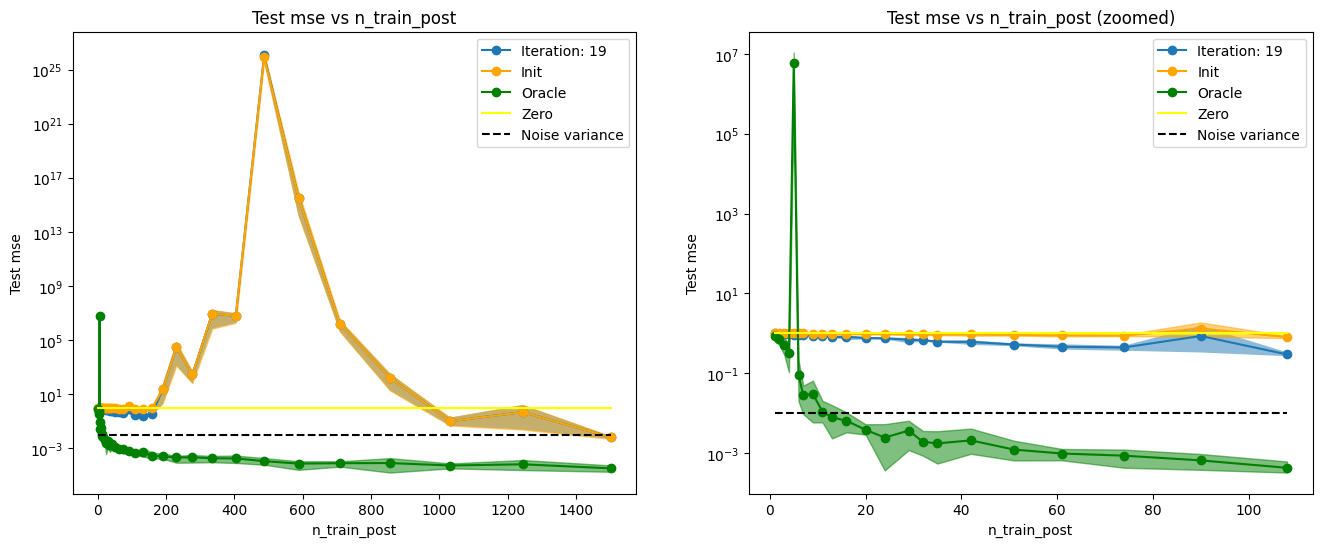

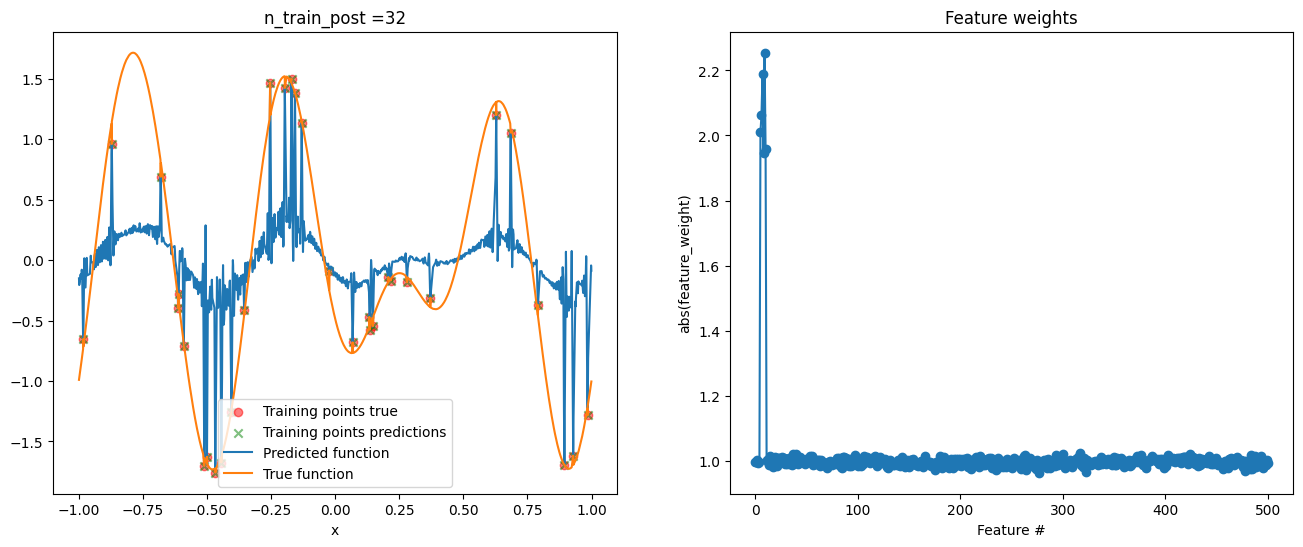

----------------------------------------------------------------------
Iteration:  30


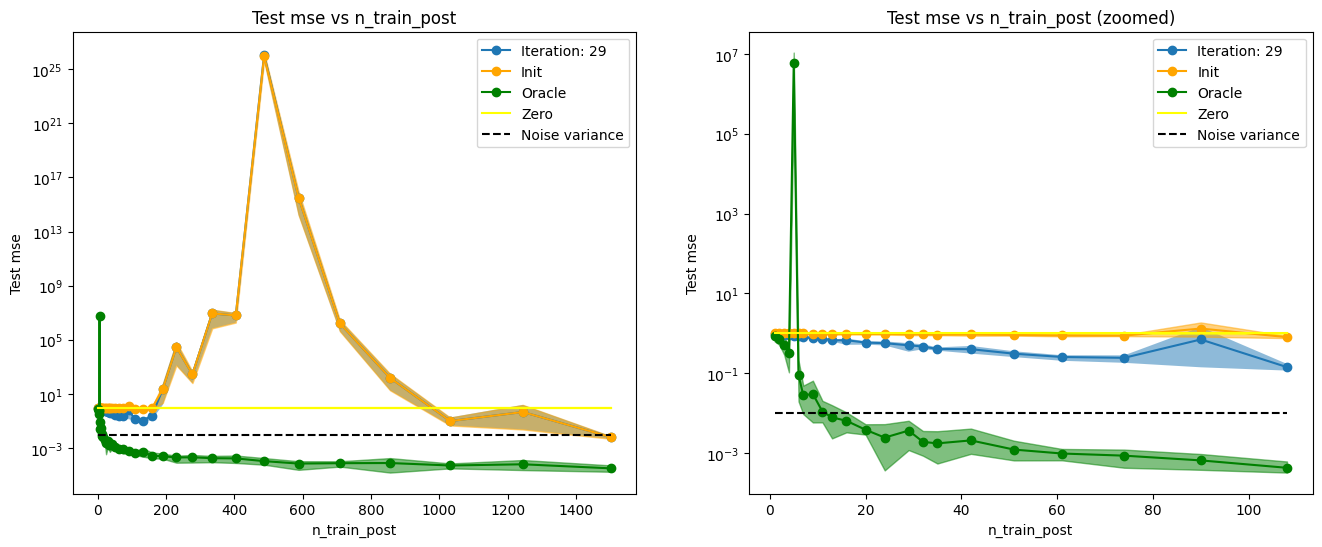

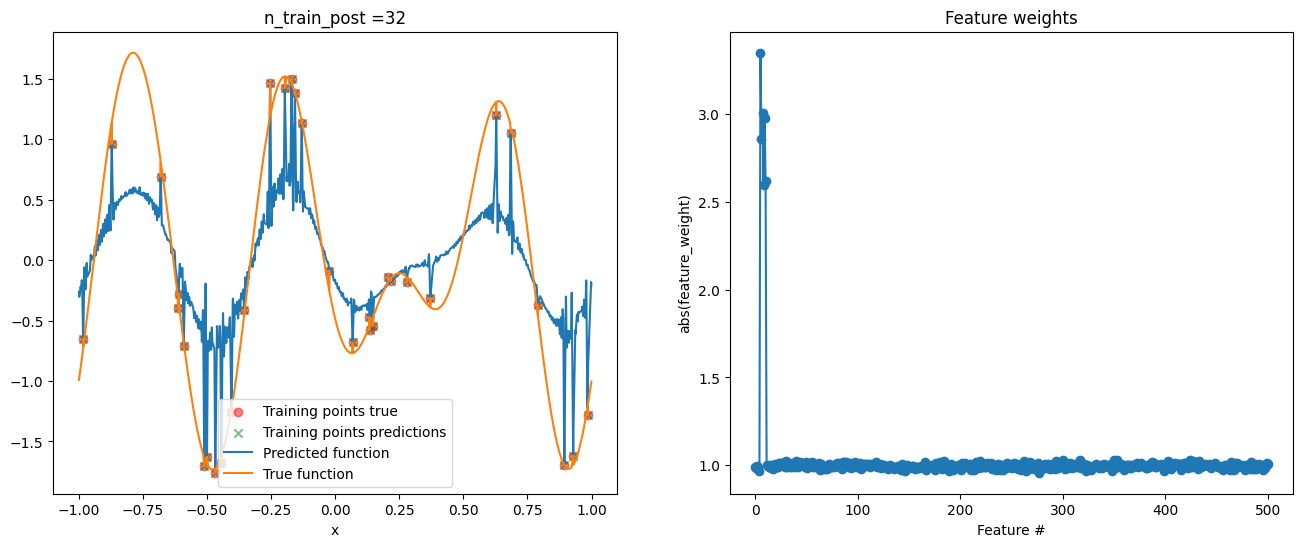

----------------------------------------------------------------------
Iteration:  40


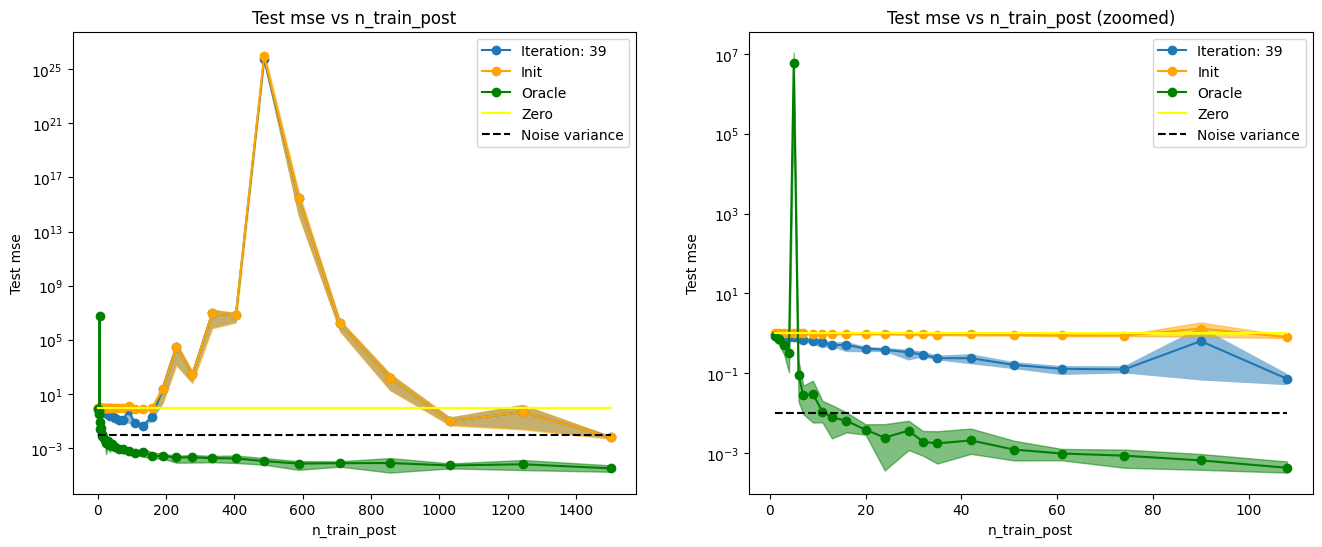

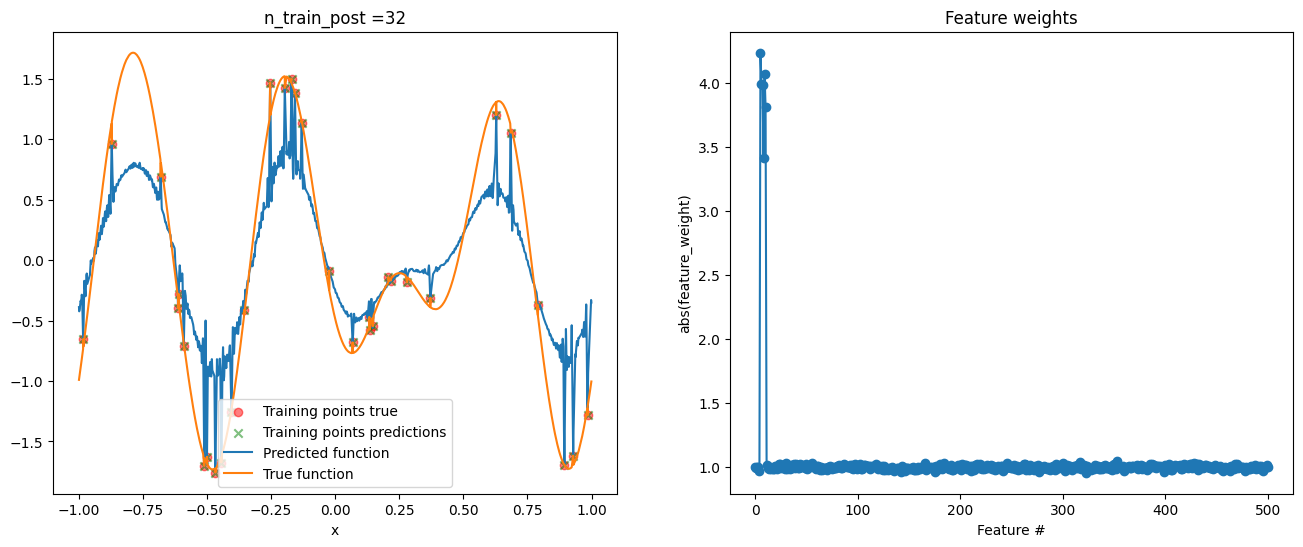

----------------------------------------------------------------------
Iteration:  50


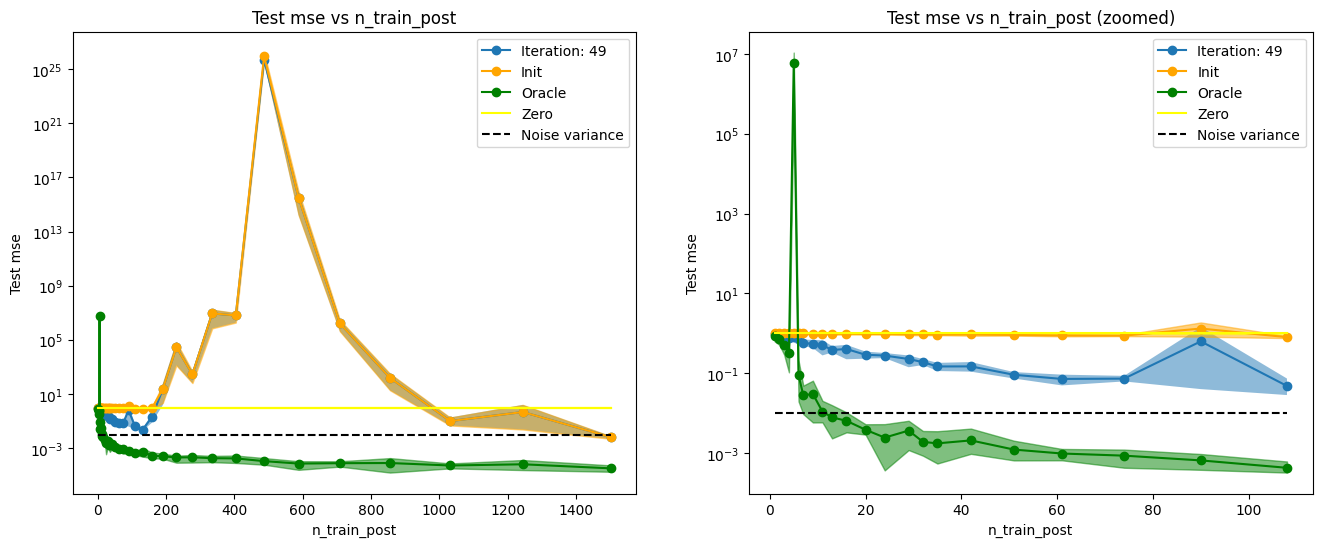

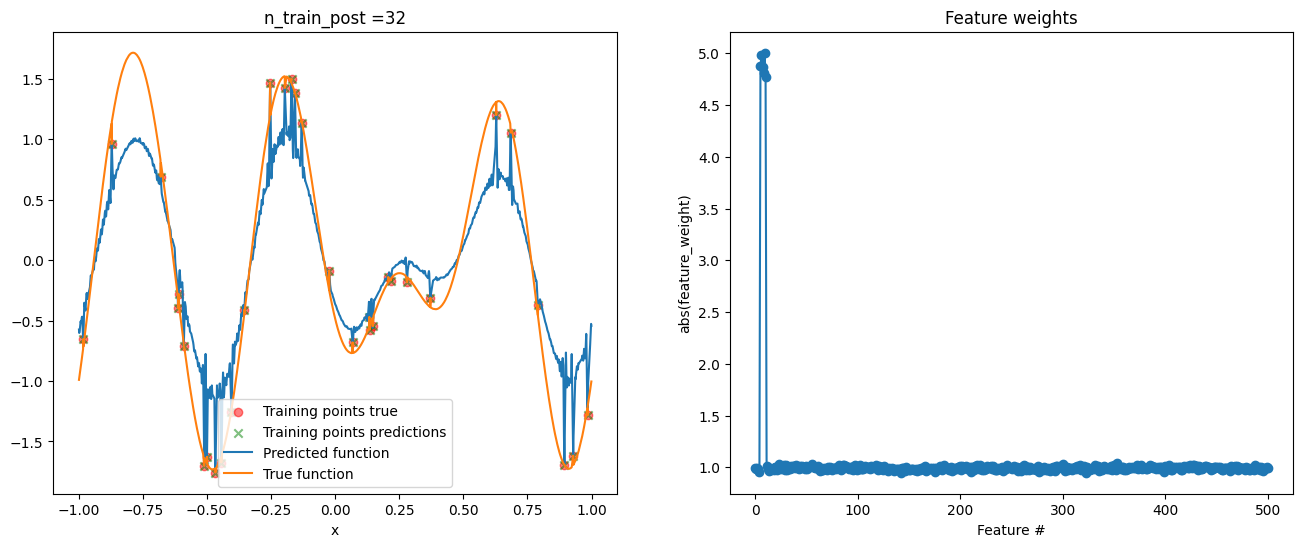

----------------------------------------------------------------------
Iteration:  60


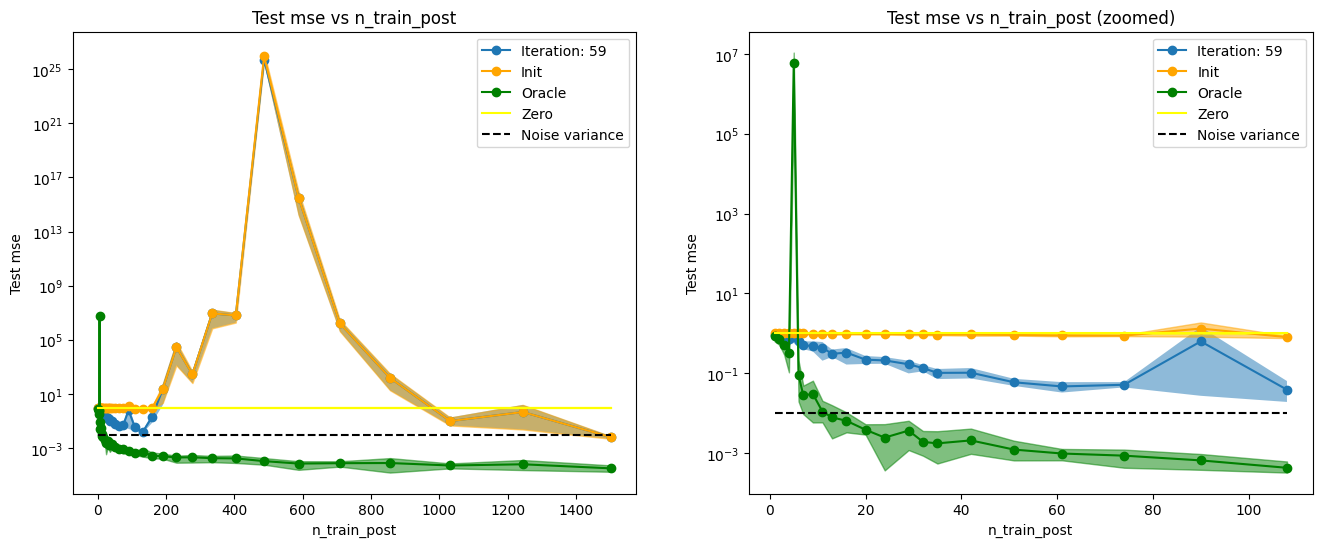

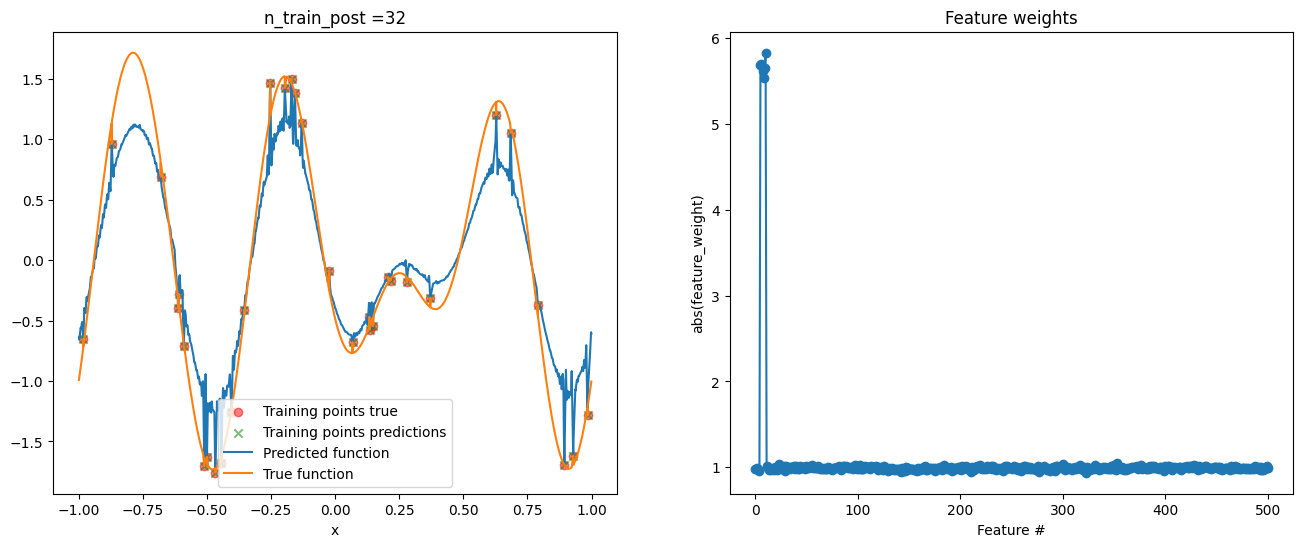

----------------------------------------------------------------------
Iteration:  70


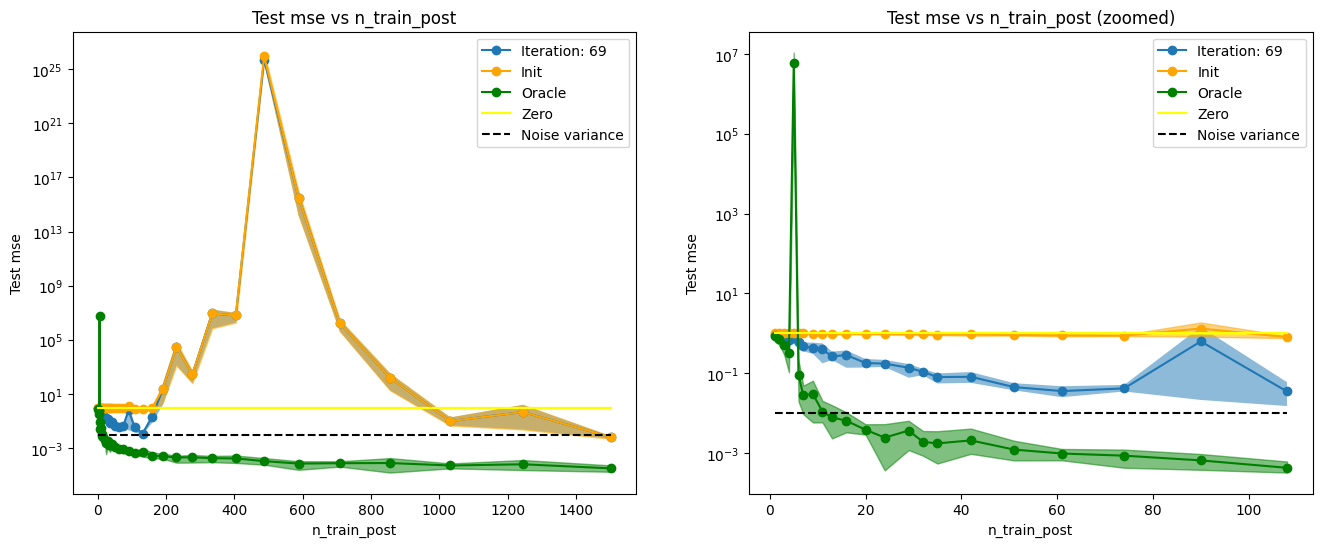

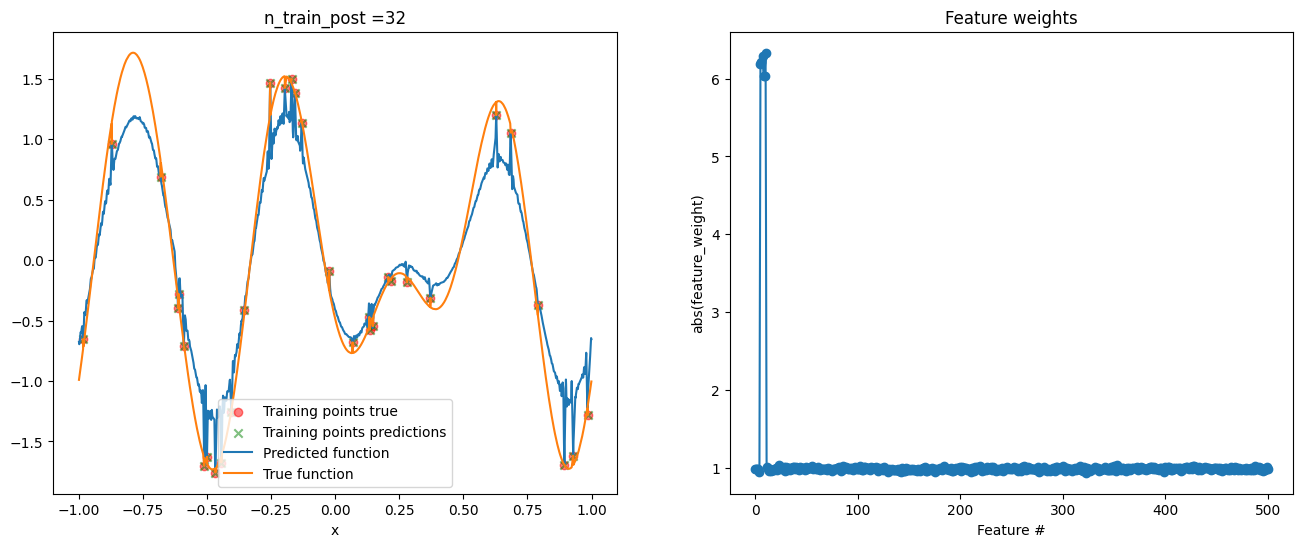

----------------------------------------------------------------------
Iteration:  80


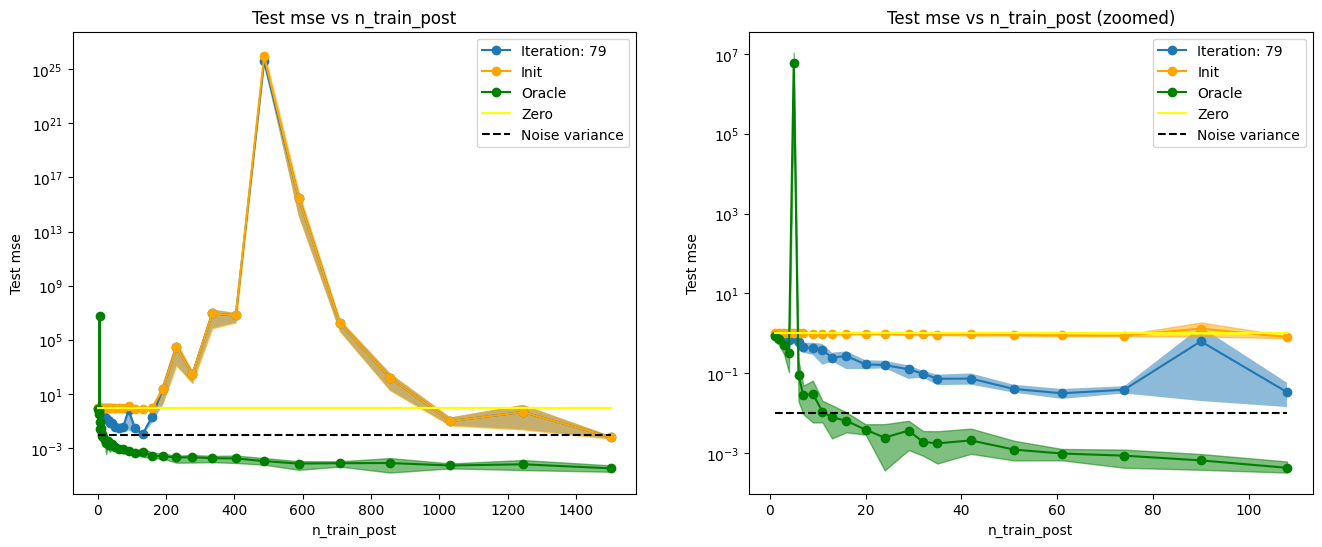

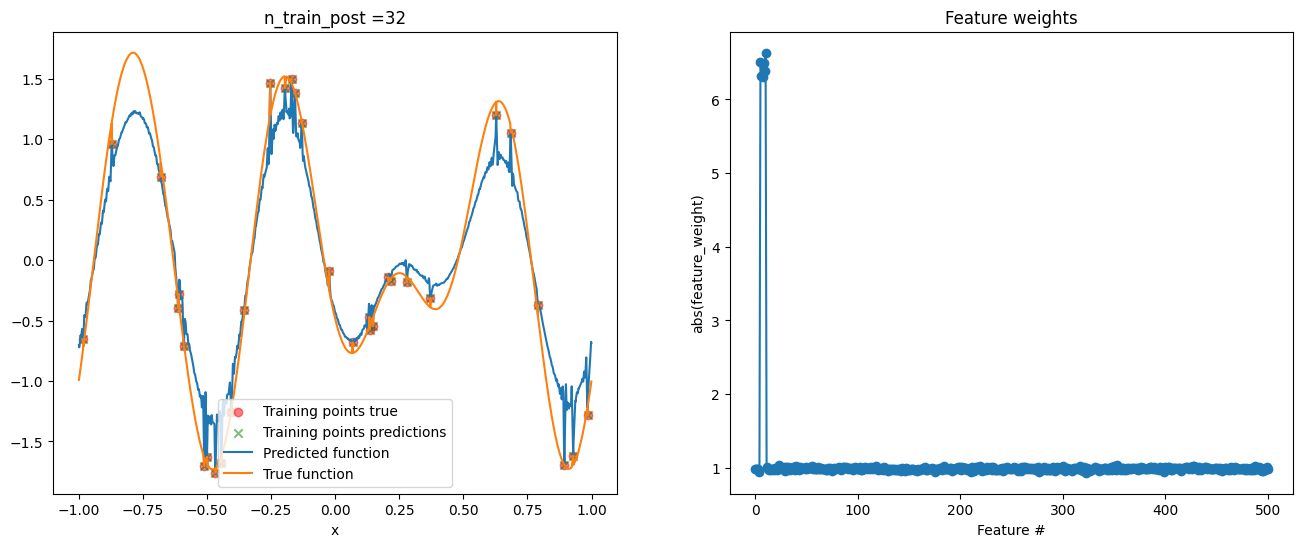

----------------------------------------------------------------------
Iteration:  90


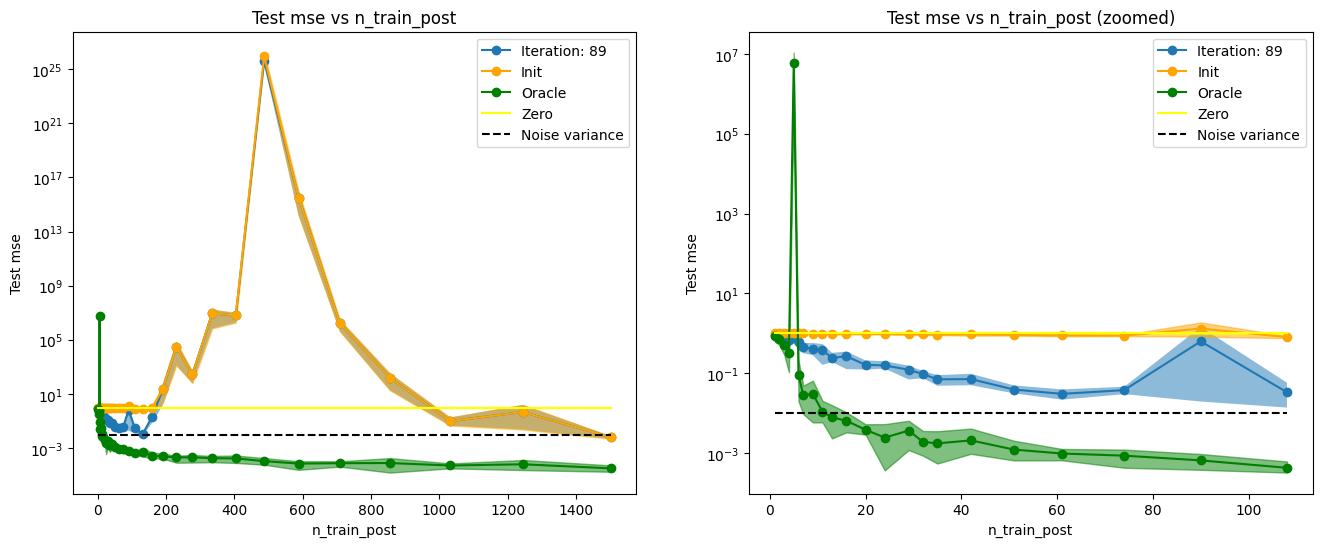

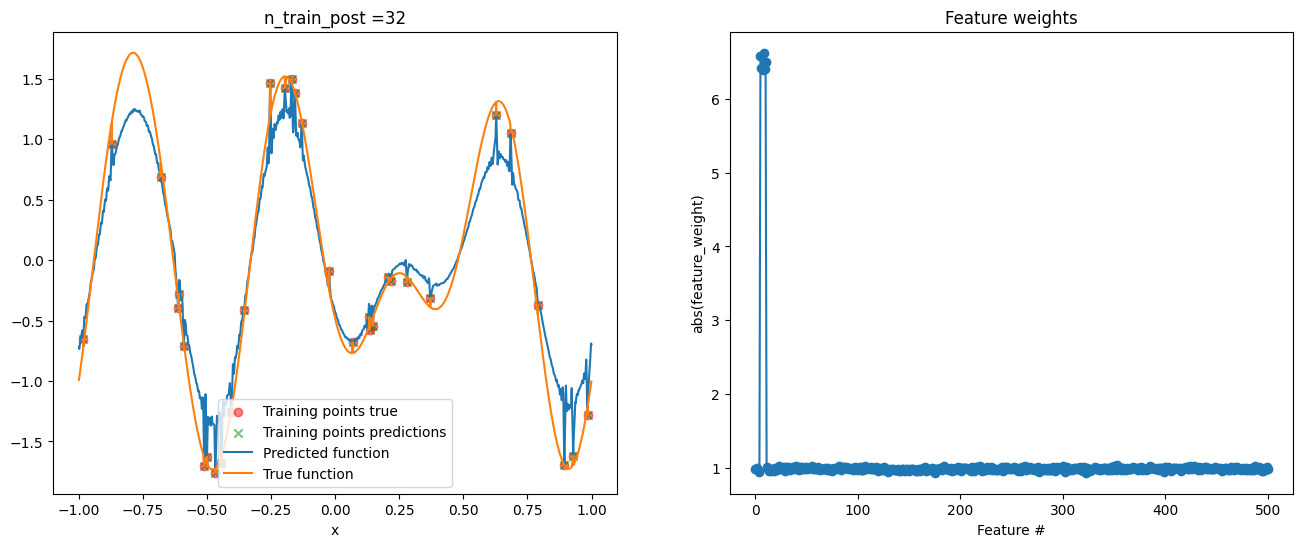

----------------------------------------------------------------------
Iteration:  100


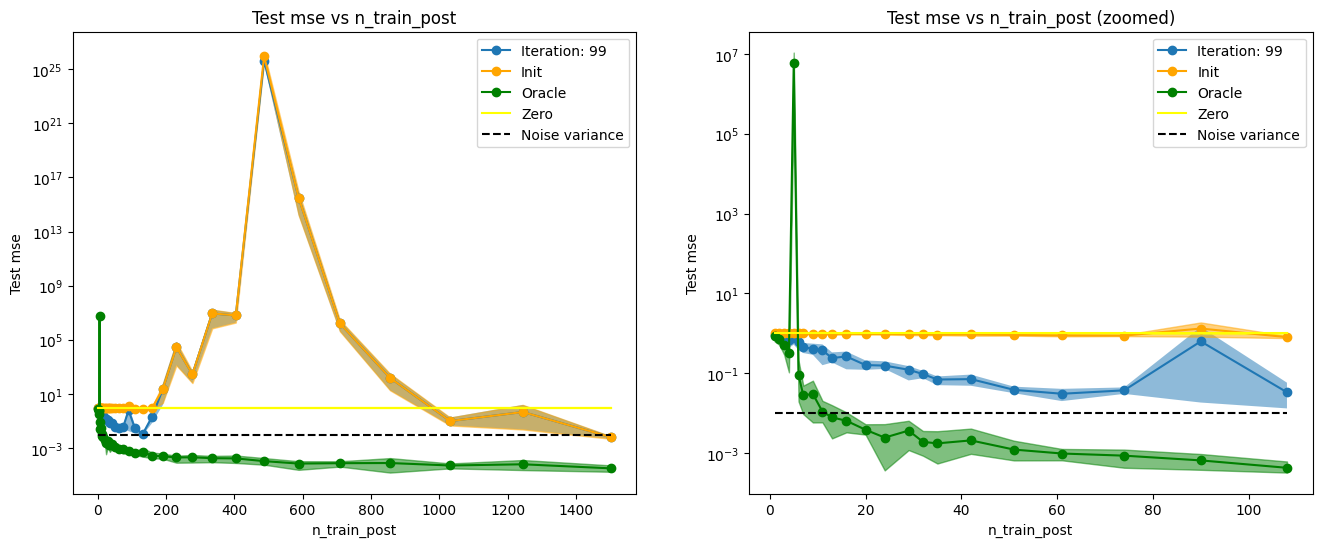

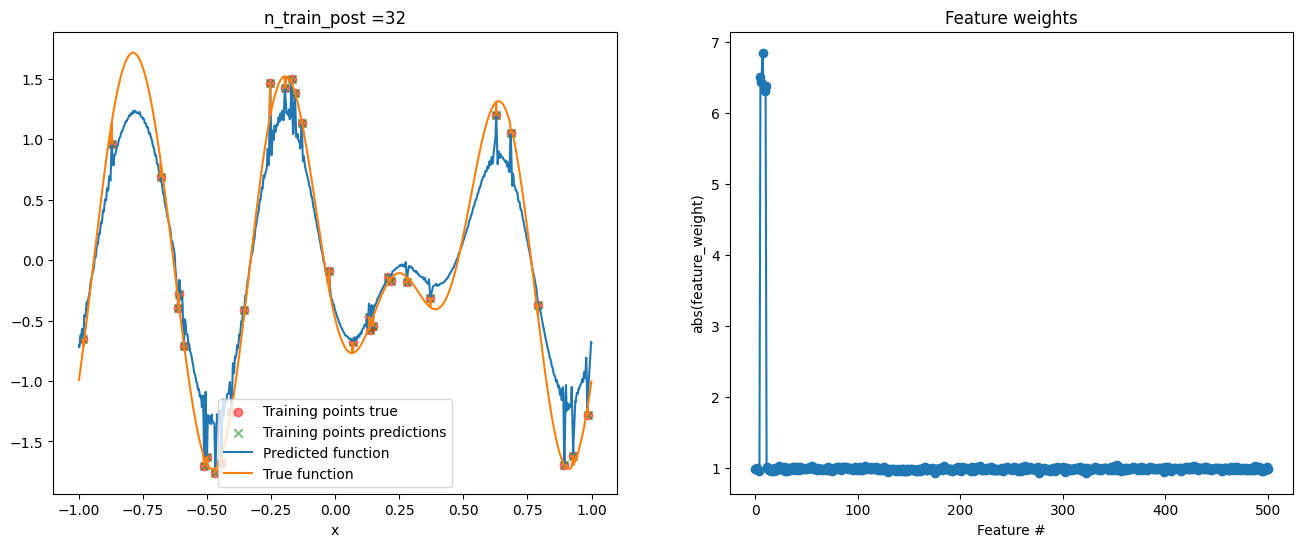

In [8]:
params_dict = get_params_dict_reg_sgd()
num_gd_steps = 1
cparams_dict = params_dict.copy()
cparams_dict['num_gd_steps'] = num_gd_steps

meta_learning_reg_sgd(cparams_dict)

## Continued...
In the next notebook `meta-learning-part2` we will see how we can use meta learning to improve performance on classification tasks. We split this problem into two notebooks for ease of running and to avoid unexpected errors caused by inconsistent states of jupyter cells. 